## Exploratory Data Analysis(EDA)

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from eda_functions import (
    plot_heatmap,
    cramers_matrix,
    mutual_information_matrix,
    conditional_entropy_matrix,
)
import eda_functions as eda

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

Даны два датасета: train, test (скачать по ссылке).

Поля датасета:
- search_id - айди поиска (айди группы, которая связана с набором объектов),
- feature_0-78 - признаки этих объектов,
- target - целевая переменная (допустим клик по этому объекту).

Задача:
- обучить модель для релевантной выдачи (можно выбрать любой алгоритм, библиотеку или фреймворк),
- посчитать метрику NDCG (для всех документов, не конкретного топа) на тестовом датасете,
- выложить код на https://github.com отдельным проектом и поделиться ссылкой в поле для ответа.
Будет плюсом, если решение завернуть в docker.


In [2]:
train = pd.read_csv(
    "../data/raw/train_df.csv",
)
test = pd.read_csv(
    "../data/raw/test_df.csv",
)

In [3]:
print(test.shape)
print(train.shape)

(1529, 81)
(15081, 81)


In [4]:
# обучающая выборка
train.head()

search_id  feature_0  feature_1  feature_2  feature_3  feature_4  \
0        758          9          0          0          1         20   
1        758          9          0          0          1         20   
2        758          9          0          0          1         20   
3        758          9          0          0          1         20   
4        758          9          0          0          1         20   

   feature_5  feature_6  feature_7  feature_8  ...  feature_70  feature_71  \
0          3         40          0          3  ...    0.204682    0.271755   
1          3         40          0          3  ...    0.195531    0.188787   
2          3         40          0          3  ...    0.148609    0.186517   
3          3         40          0          3  ...    0.223748    0.229039   
4          3         40          0          3  ...    0.170935    0.249031   

   feature_72  feature_73  feature_74  feature_75  feature_76  feature_77  \
0    0.055623           0           0           0     0.38648         0.0   
1    0.036914           0           0           0     0.10982         0.0   
2    0.027718           0           0           0     0.03674         0.0   
3    0.051247           0           0           0     0.00000         0.0   
4    0.042568           0           0           0     0.00000         0.0   

   feature_78  target  
0         0.0       0  
1         0.0       0  
2         0.0       0  
3         0.0       0  
4         0.0       0  

[5 rows x 81 columns]

In [5]:
# тестовая выборка
test.head()

search_id  feature_0  feature_1  feature_2  feature_3  feature_4  \
0      10655          9          0          0          1         20   
1      10655          9          0          0          1         20   
2      10655          9          0          0          1         20   
3      10655          9          0          0          1         20   
4      10655          9          0          0          1         20   

   feature_5  feature_6  feature_7  feature_8  ...  feature_70  feature_71  \
0          4         40          0          0  ...    0.148830    0.196644   
1          4         40          0          0  ...    0.119724    0.174199   
2          4         40          0          0  ...    0.160606    0.198780   
3          4         40          0          0  ...    0.180191    0.187882   
4          4         40          0          0  ...    0.117308    0.153586   

   feature_72  feature_73  feature_74  feature_75  feature_76  feature_77  \
0    0.029267           0           0           0     0.03674         0.0   
1    0.020856           0           0           0     0.00000         0.0   
2    0.031925           0           0           0     0.00000         0.0   
3    0.033855           0           0           0     0.00000         0.0   
4    0.018017           0           0           0     0.00000         0.0   

   feature_78  target  
0         0.0       0  
1         0.0       0  
2         0.0       0  
3         0.0       0  
4         0.0       0  

[5 rows x 81 columns]

In [6]:
print(
    f"Количество пропущенных значений в обучающем датасете{train.isnull().sum().sum()}"
)
print(train.isnull().sum())

Количество пропущенных значений в обучающем датасете0
search_id     0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_75    0
feature_76    0
feature_77    0
feature_78    0
target        0
Length: 81, dtype: int64


In [7]:
print(
    f"Количество пропущенных значений в тестовом датасете {test.isnull().sum().sum()}"
)
print(test.isnull().sum())

Количество пропущенных значений в тестовом датасете 0
search_id     0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_75    0
feature_76    0
feature_77    0
feature_78    0
target        0
Length: 81, dtype: int64


##### Распредление целевой переменной

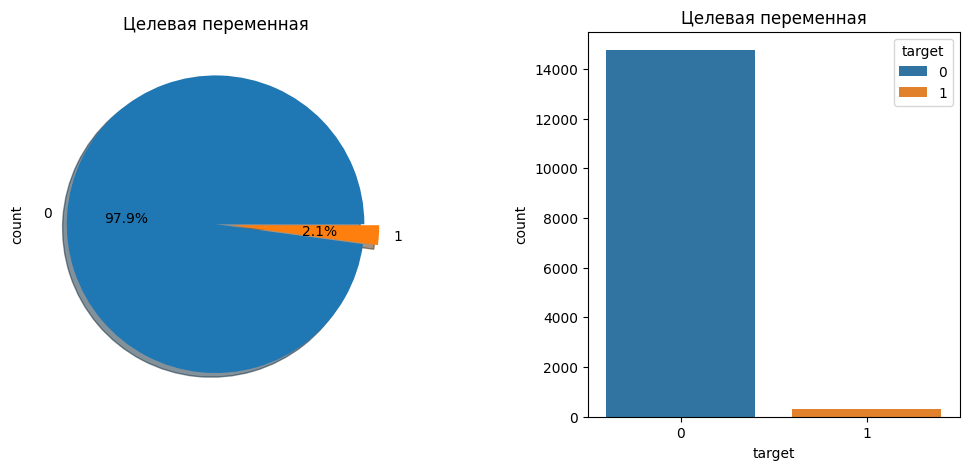

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Первый график - круговая диаграмма
train["target"].value_counts().plot.pie(
    explode=[0, 0.1], autopct="%1.1f%%", ax=axes[0], shadow=True
)
axes[0].set_title("Целевая переменная")
axes[1].set_ylabel("")

# Второй график - гистограмма
sns.countplot(x="target", data=train, ax=axes[1], hue="target")
axes[1].set_title("Целевая переменная")

# Изменение расстояния между графиками
plt.subplots_adjust(
    wspace=0.5
)  # Установка горизонтального пространства между графиками
plt.show()

Виден дисбаланс классов примерно в 45 раз 

### Распределение признаков

Categorical Features:

Есть предположение, что не все признаки являются непрерывными


In [9]:
train.head(20).T.iloc[:20]

0      1      2      3      4      5      6      7      8   \
search_id   758.0  758.0  758.0  758.0  758.0  758.0  758.0  758.0  758.0   
feature_0     9.0    9.0    9.0    9.0    9.0    9.0    9.0    9.0    9.0   
feature_1     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
feature_2     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
feature_3     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
feature_4    20.0   20.0   20.0   20.0   20.0   20.0   20.0   20.0   20.0   
feature_5     3.0    3.0    3.0    3.0    3.0    3.0    3.0    3.0    3.0   
feature_6    40.0   40.0   40.0   40.0   40.0   40.0   40.0   40.0   40.0   
feature_7     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
feature_8     3.0    3.0    3.0    3.0    3.0    3.0    3.0    3.0    3.0   
feature_9     1.0    0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
feature_10    0.0    0.0    0.0    1.0    1.0    0.0    1.0    1.0    0.0   
feature_11    0.0    0.0    0.0    1.0    1.0    1.0    1.0    0.0    0.0   
feature_12    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
feature_13    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
feature_14    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
feature_15    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
feature_16    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
feature_17    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
feature_18    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

               9      10     11     12     13     14     15      16      17  \
search_id   758.0  758.0  758.0  758.0  758.0  758.0  758.0  1569.0  1569.0   
feature_0     9.0    9.0    9.0    9.0    9.0    9.0    9.0     9.0     9.0   
feature_1     0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0   
feature_2     0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0   
feature_3     1.0    1.0    1.0    1.0    1.0    1.0    1.0     0.0     0.0   
feature_4    20.0   20.0   20.0   20.0   20.0   20.0   20.0     9.0     9.0   
feature_5     3.0    3.0    3.0    3.0    3.0    3.0    3.0     4.0     4.0   
feature_6    40.0   40.0   40.0   40.0   40.0   40.0   40.0    34.0    34.0   
feature_7     0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0   
feature_8     3.0    3.0    3.0    3.0    3.0    3.0    3.0     0.0     0.0   
feature_9     1.0    1.0    1.0    1.0    1.0    1.0    1.0     1.0     0.0   
feature_10    0.0    1.0    0.0    0.0    0.0    1.0    0.0     0.0     0.0   
feature_11    1.0    0.0    0.0    1.0    1.0    0.0    1.0     0.0     0.0   
feature_12    0.0    0.0    0.0    0.0    1.0    0.0    0.0     0.0     0.0   
feature_13    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0   
feature_14    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0   
feature_15    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0   
feature_16    1.0    1.0    1.0    1.0    1.0    1.0    1.0     0.0     0.0   
feature_17    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0   
feature_18    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0     0.0   

                18      19  
search_id   1569.0  1569.0  
feature_0      9.0     9.0  
feature_1      0.0     0.0  
feature_2      0.0     0.0  
feature_3      0.0     0.0  
feature_4      9.0     9.0  
feature_5      4.0     4.0  
feature_6     34.0    34.0  
feature_7      0.0     0.0  
feature_8      0.0     0.0  
feature_9      1.0     1.0  
feature_10     0.0     0.0  
feature_11     0.0     0.0  
feature_12     0.0     0.0  
feature_13     0.0     0.0  
feature_14     0.0     0.0  
feature_15     0.0     0.0  
feature_16     0.0     0.0  
feature_17     0.0     0.0  
feature_18     0.0     0.0

#### Распределение категориальных переменных

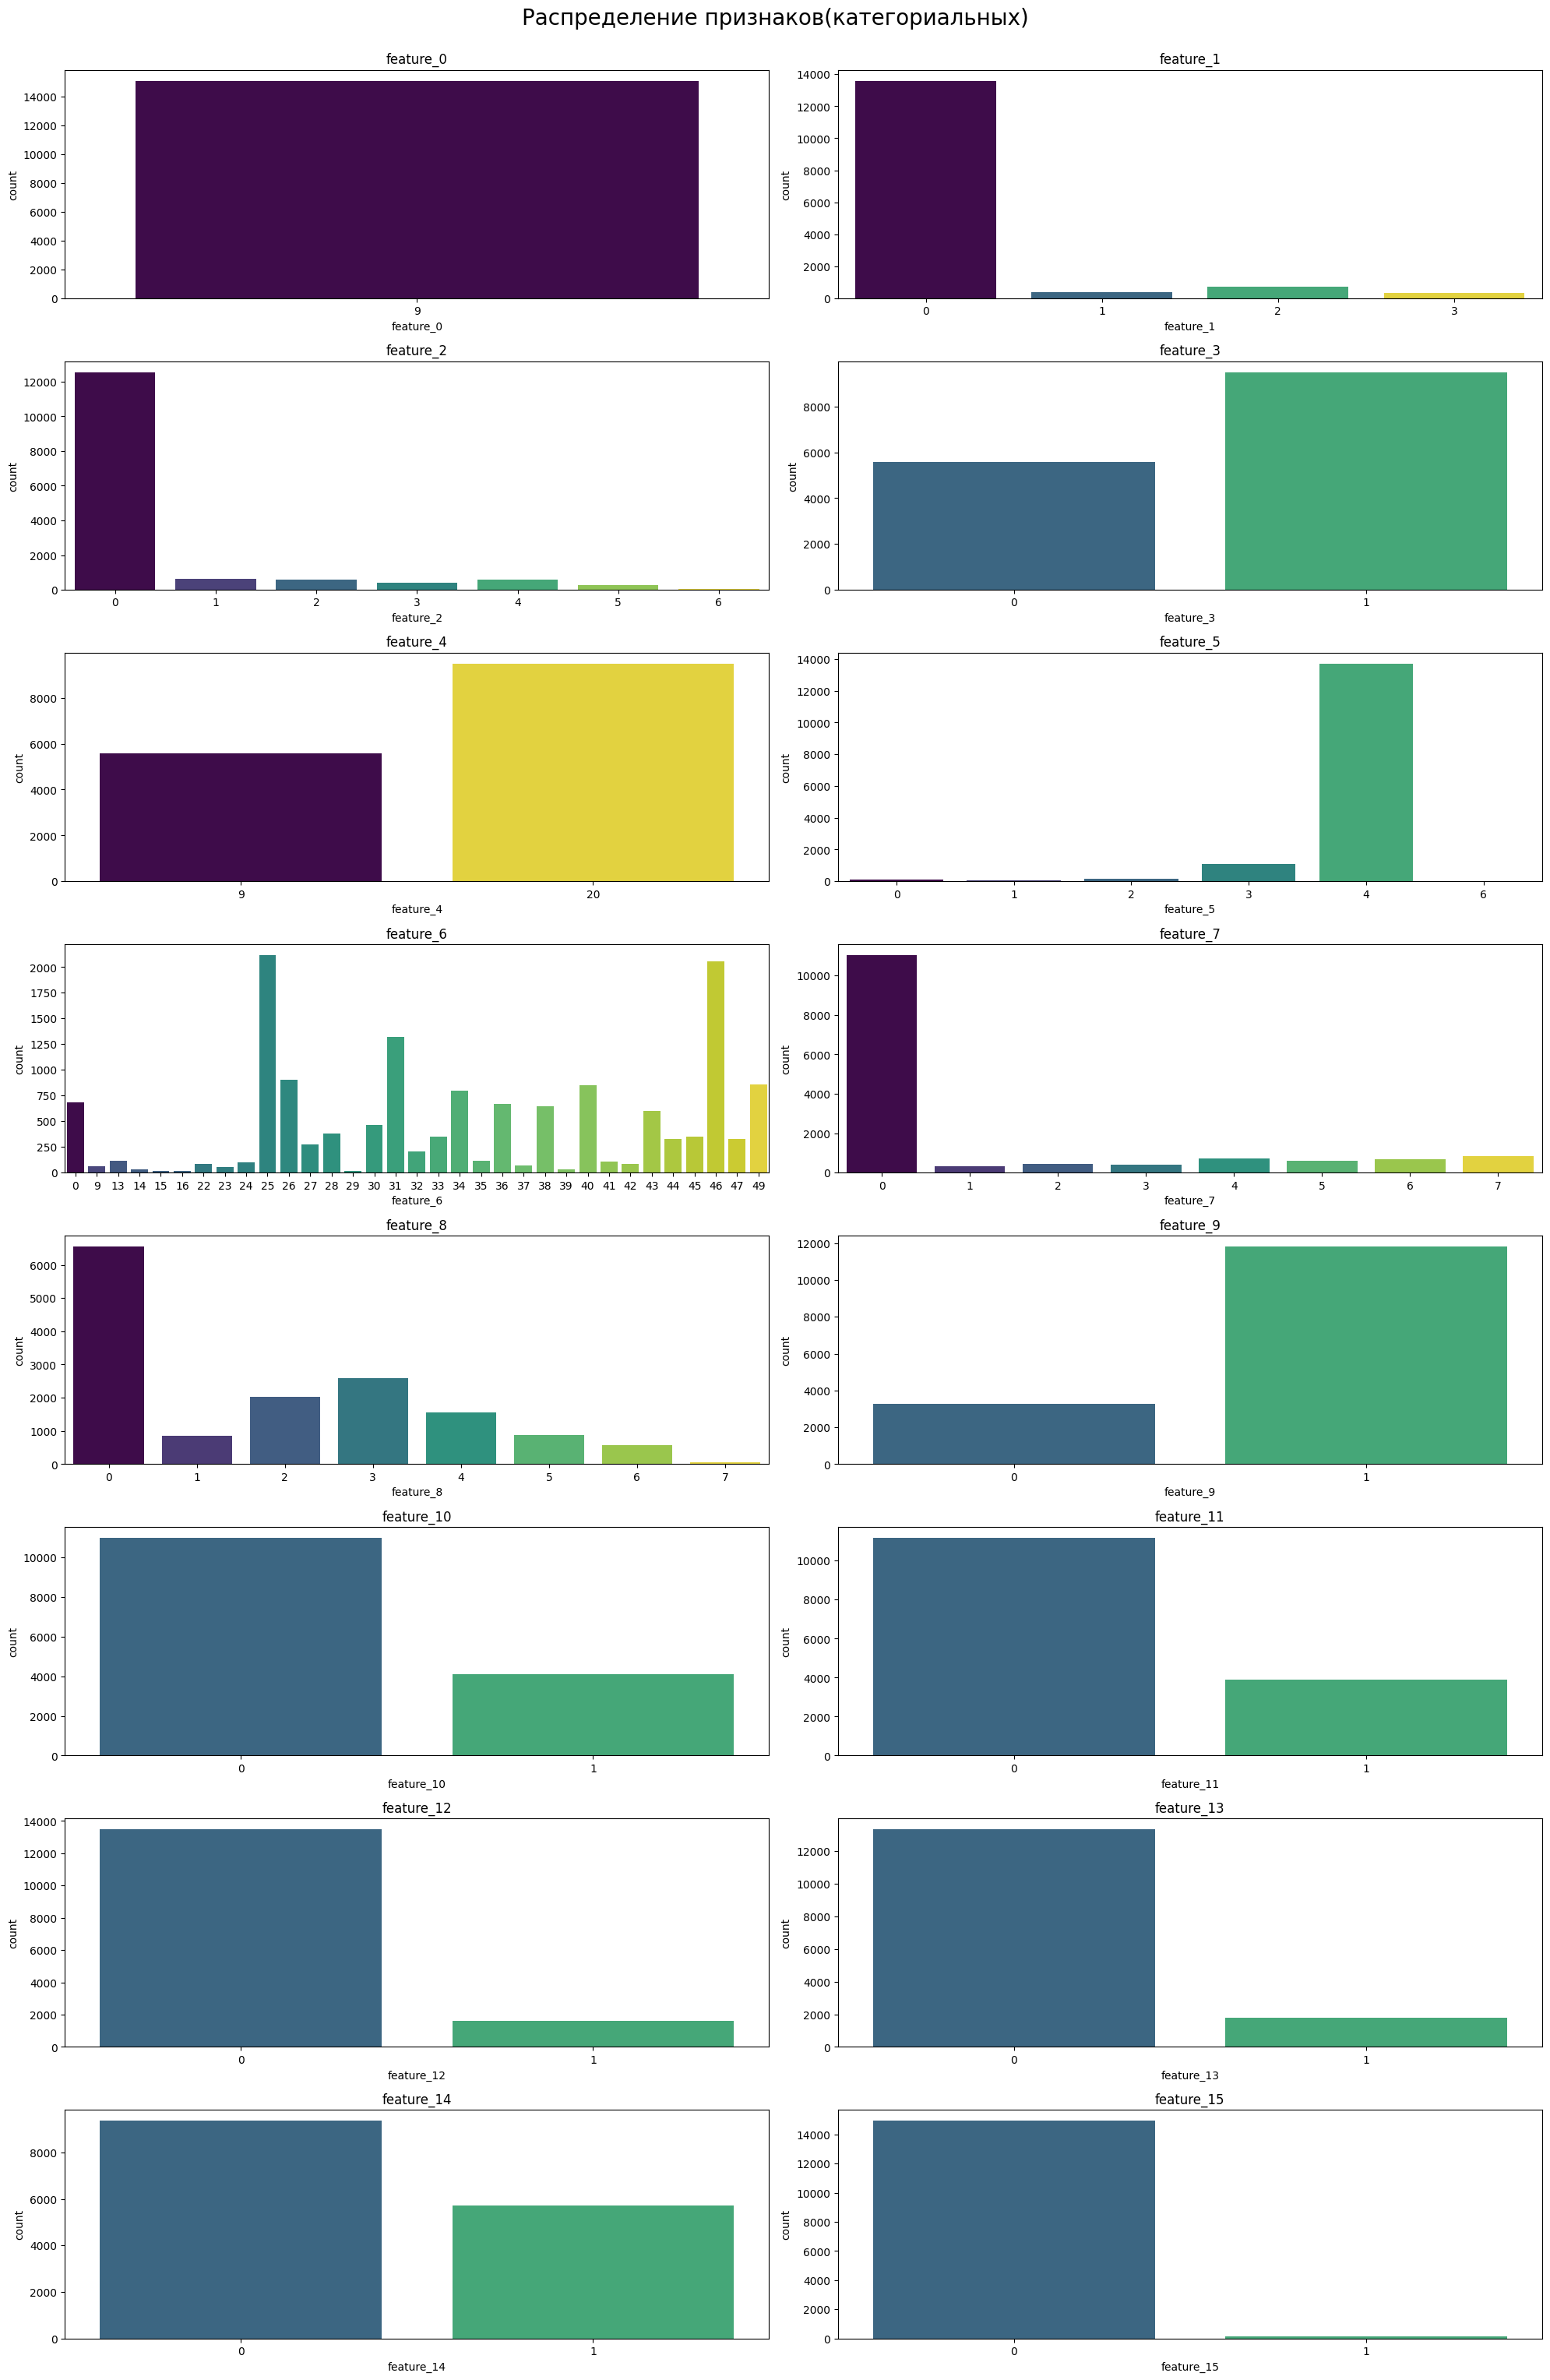

In [10]:
# список категориальных переменных
catcol = train.columns[1:17]

# распределение категориальных переменных
plt.figure(figsize=(20, 60))
for i, column in enumerate(catcol):
    plt.subplot(len(catcol), 2, i + 1)
    plt.suptitle("Распределение признаков(категориальных)", fontsize=20, x=0.5, y=1)

    # Устанавливаем 'hue' равным текущему столбцу и отключаем легенду
    sns.countplot(data=train, x=column, hue=column, palette="viridis", legend=False)
    plt.title(f"{column}")
    plt.tight_layout()

#### Распределение непрерывных величин

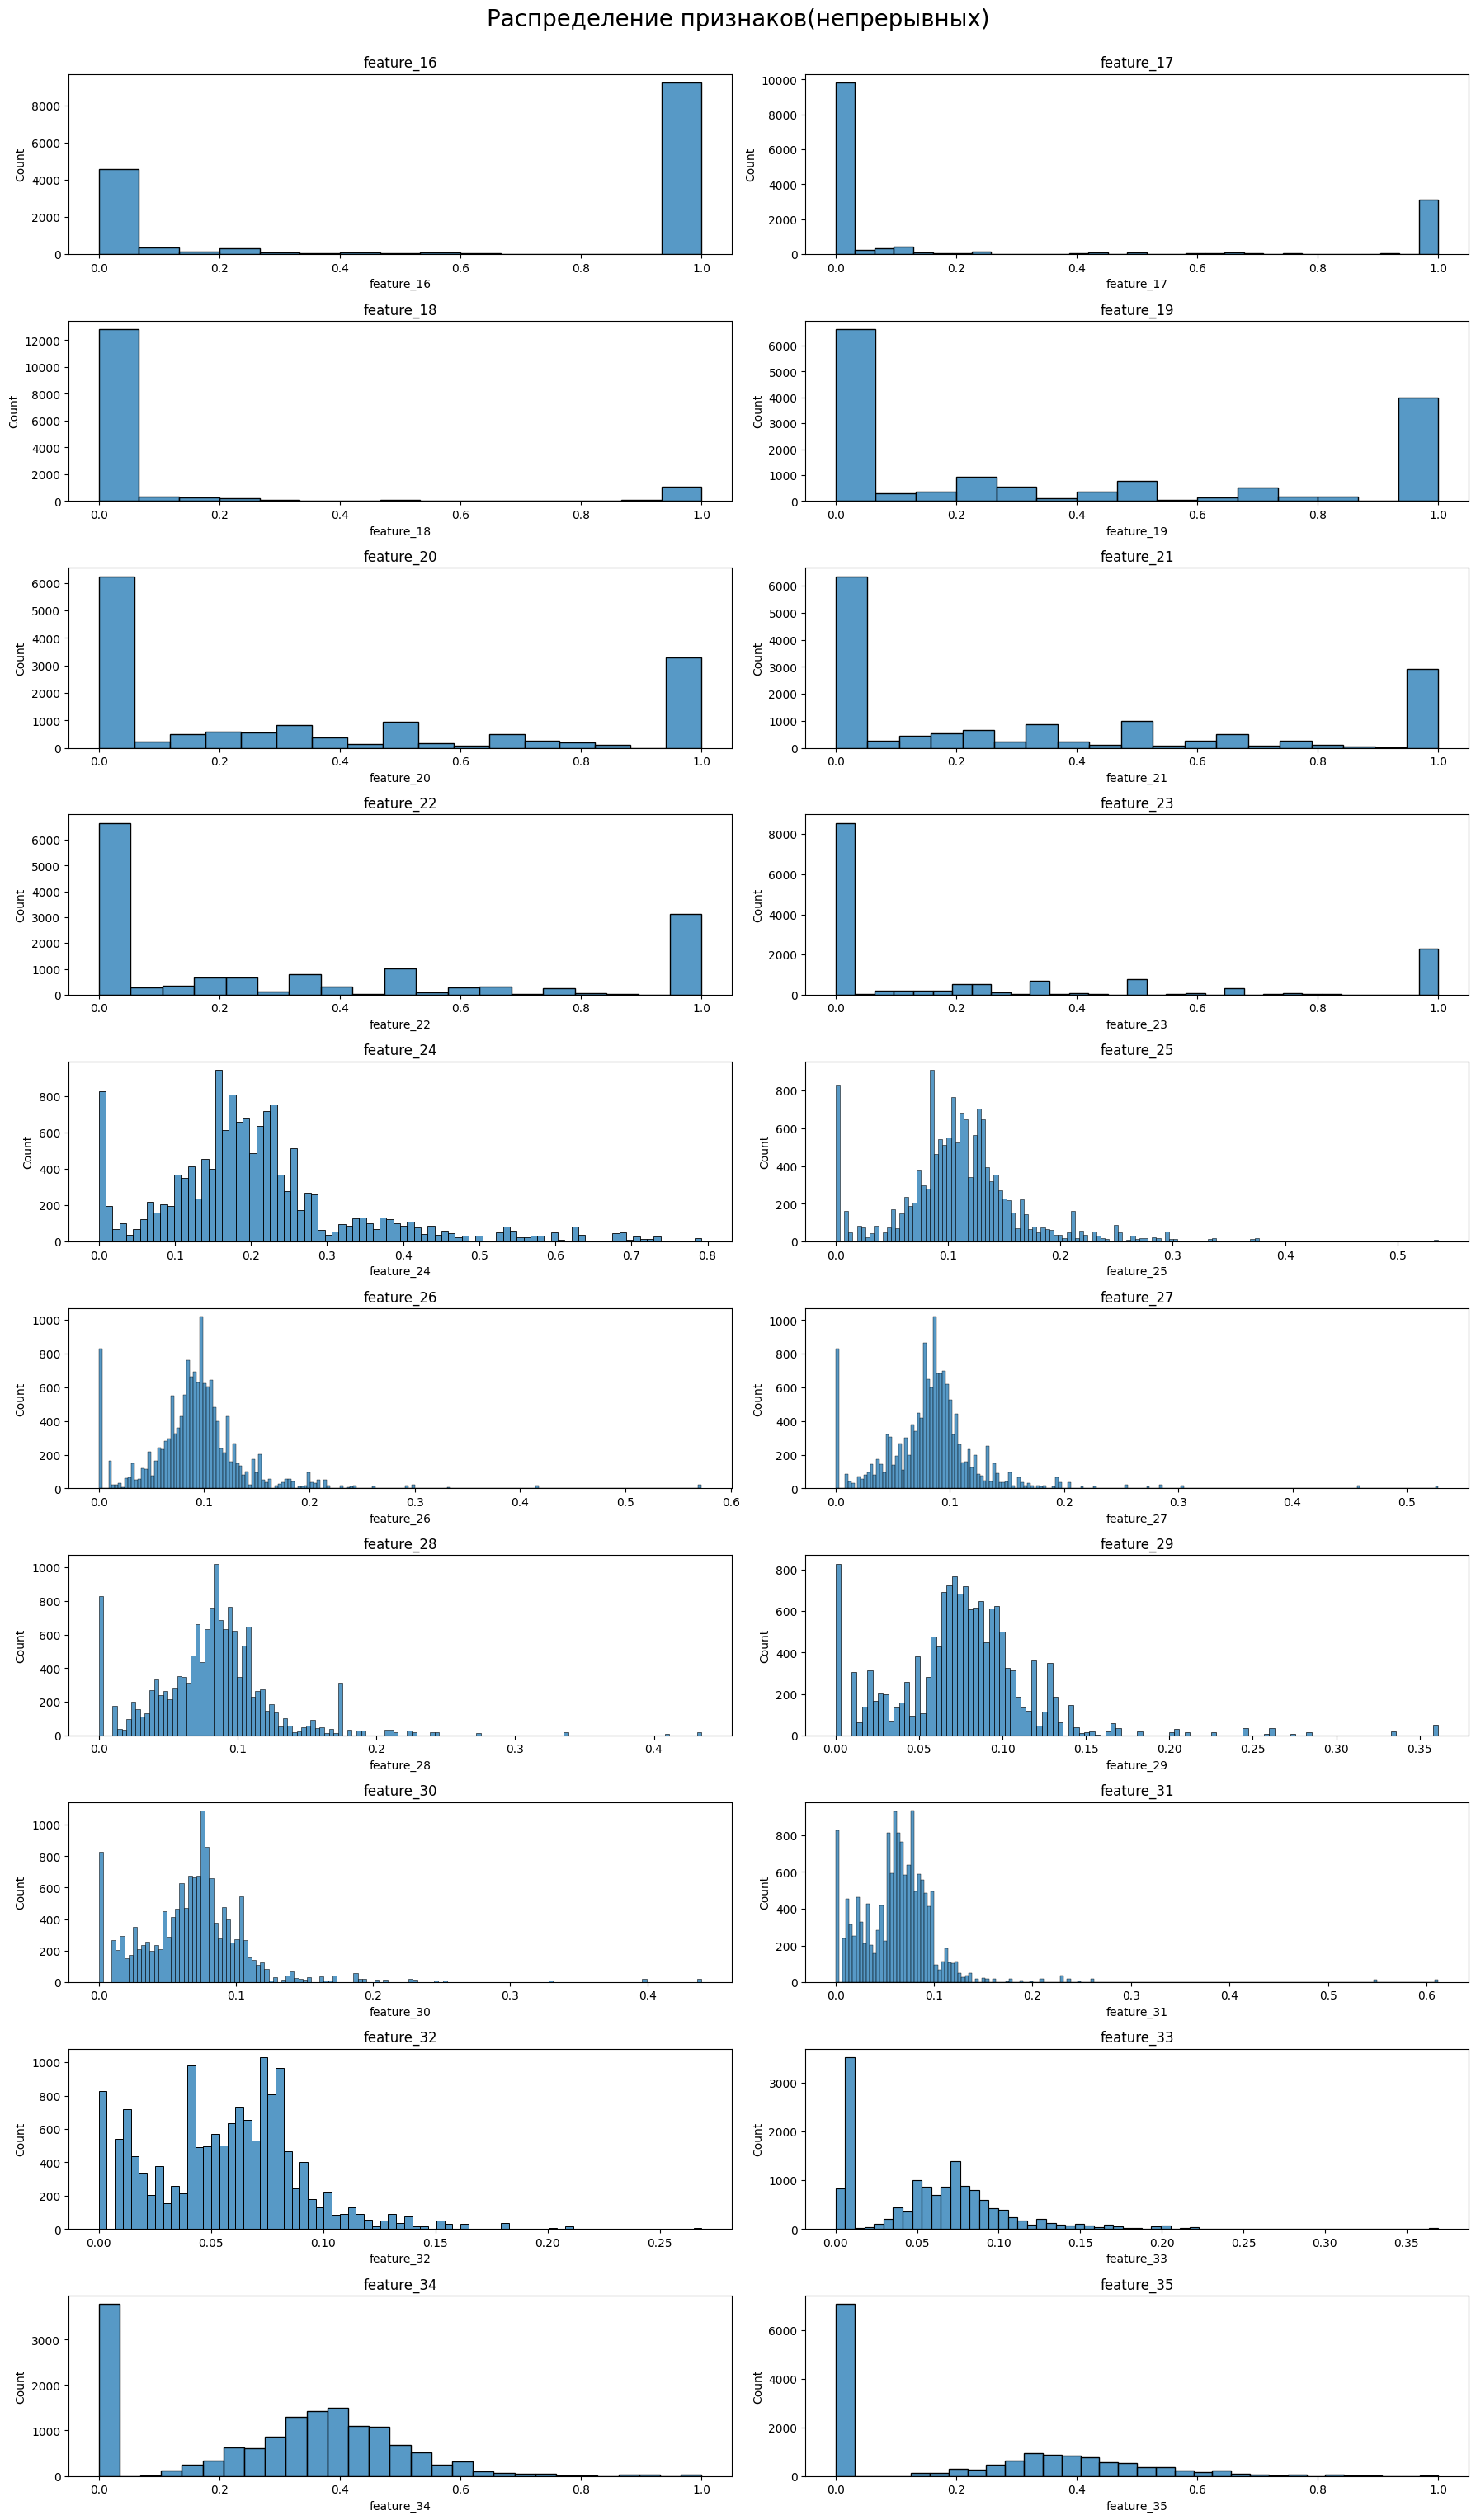

In [11]:
# распределение непрерывных величин
distcol = train.columns[17:37]

plt.figure(figsize=(18, 60))
plt.suptitle("Распределение признаков(непрерывных)", fontsize=20, x=0.5, y=1)
for i, column in enumerate(distcol):
    plt.subplot(len(distcol), 2, i + 1)

    sns.histplot(
        data=train,
        x=column,
        kde=False,
    )
    plt.title(f"{column}")
    plt.tight_layout()

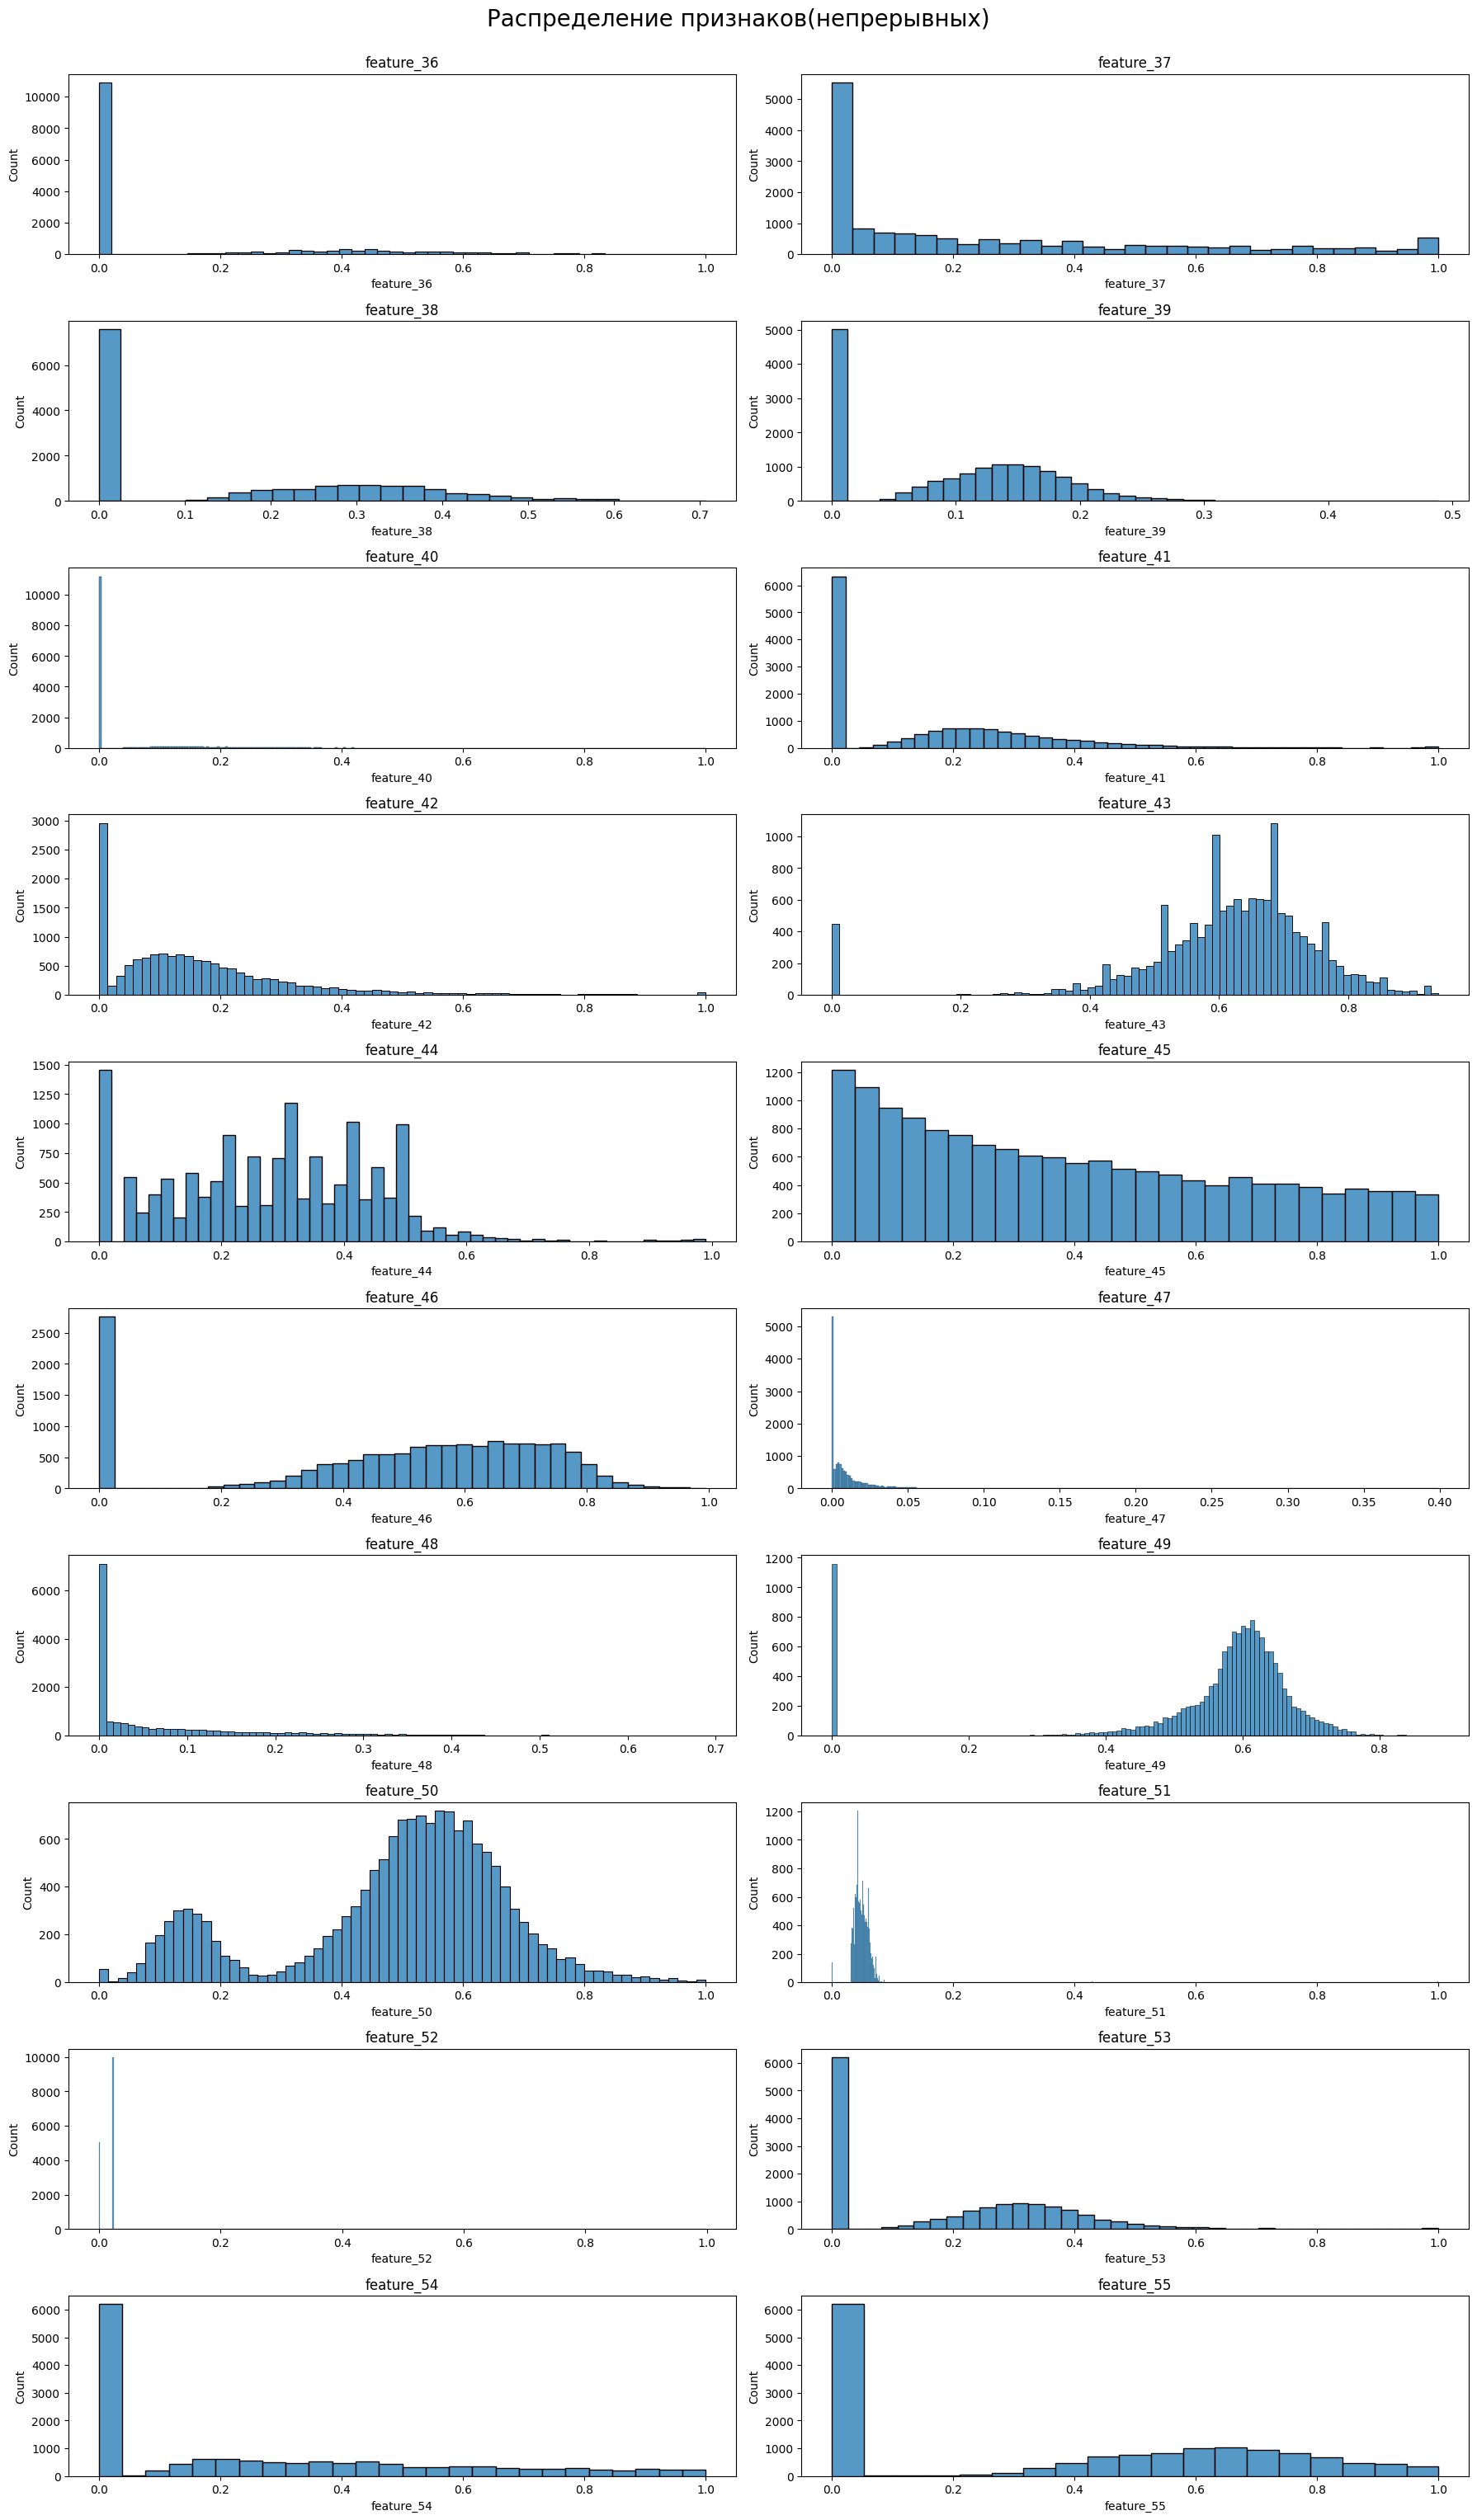

In [12]:
# распределение непрерывных величин
distcol = train.columns[37:57]

plt.figure(figsize=(18, 60))
plt.suptitle("Распределение признаков(непрерывных)", fontsize=20, x=0.5, y=1)
for i, column in enumerate(distcol):
    plt.subplot(len(distcol), 2, i + 1)

    sns.histplot(
        data=train,
        x=column,
        kde=False,
    )
    plt.title(f"{column}")
    plt.tight_layout()

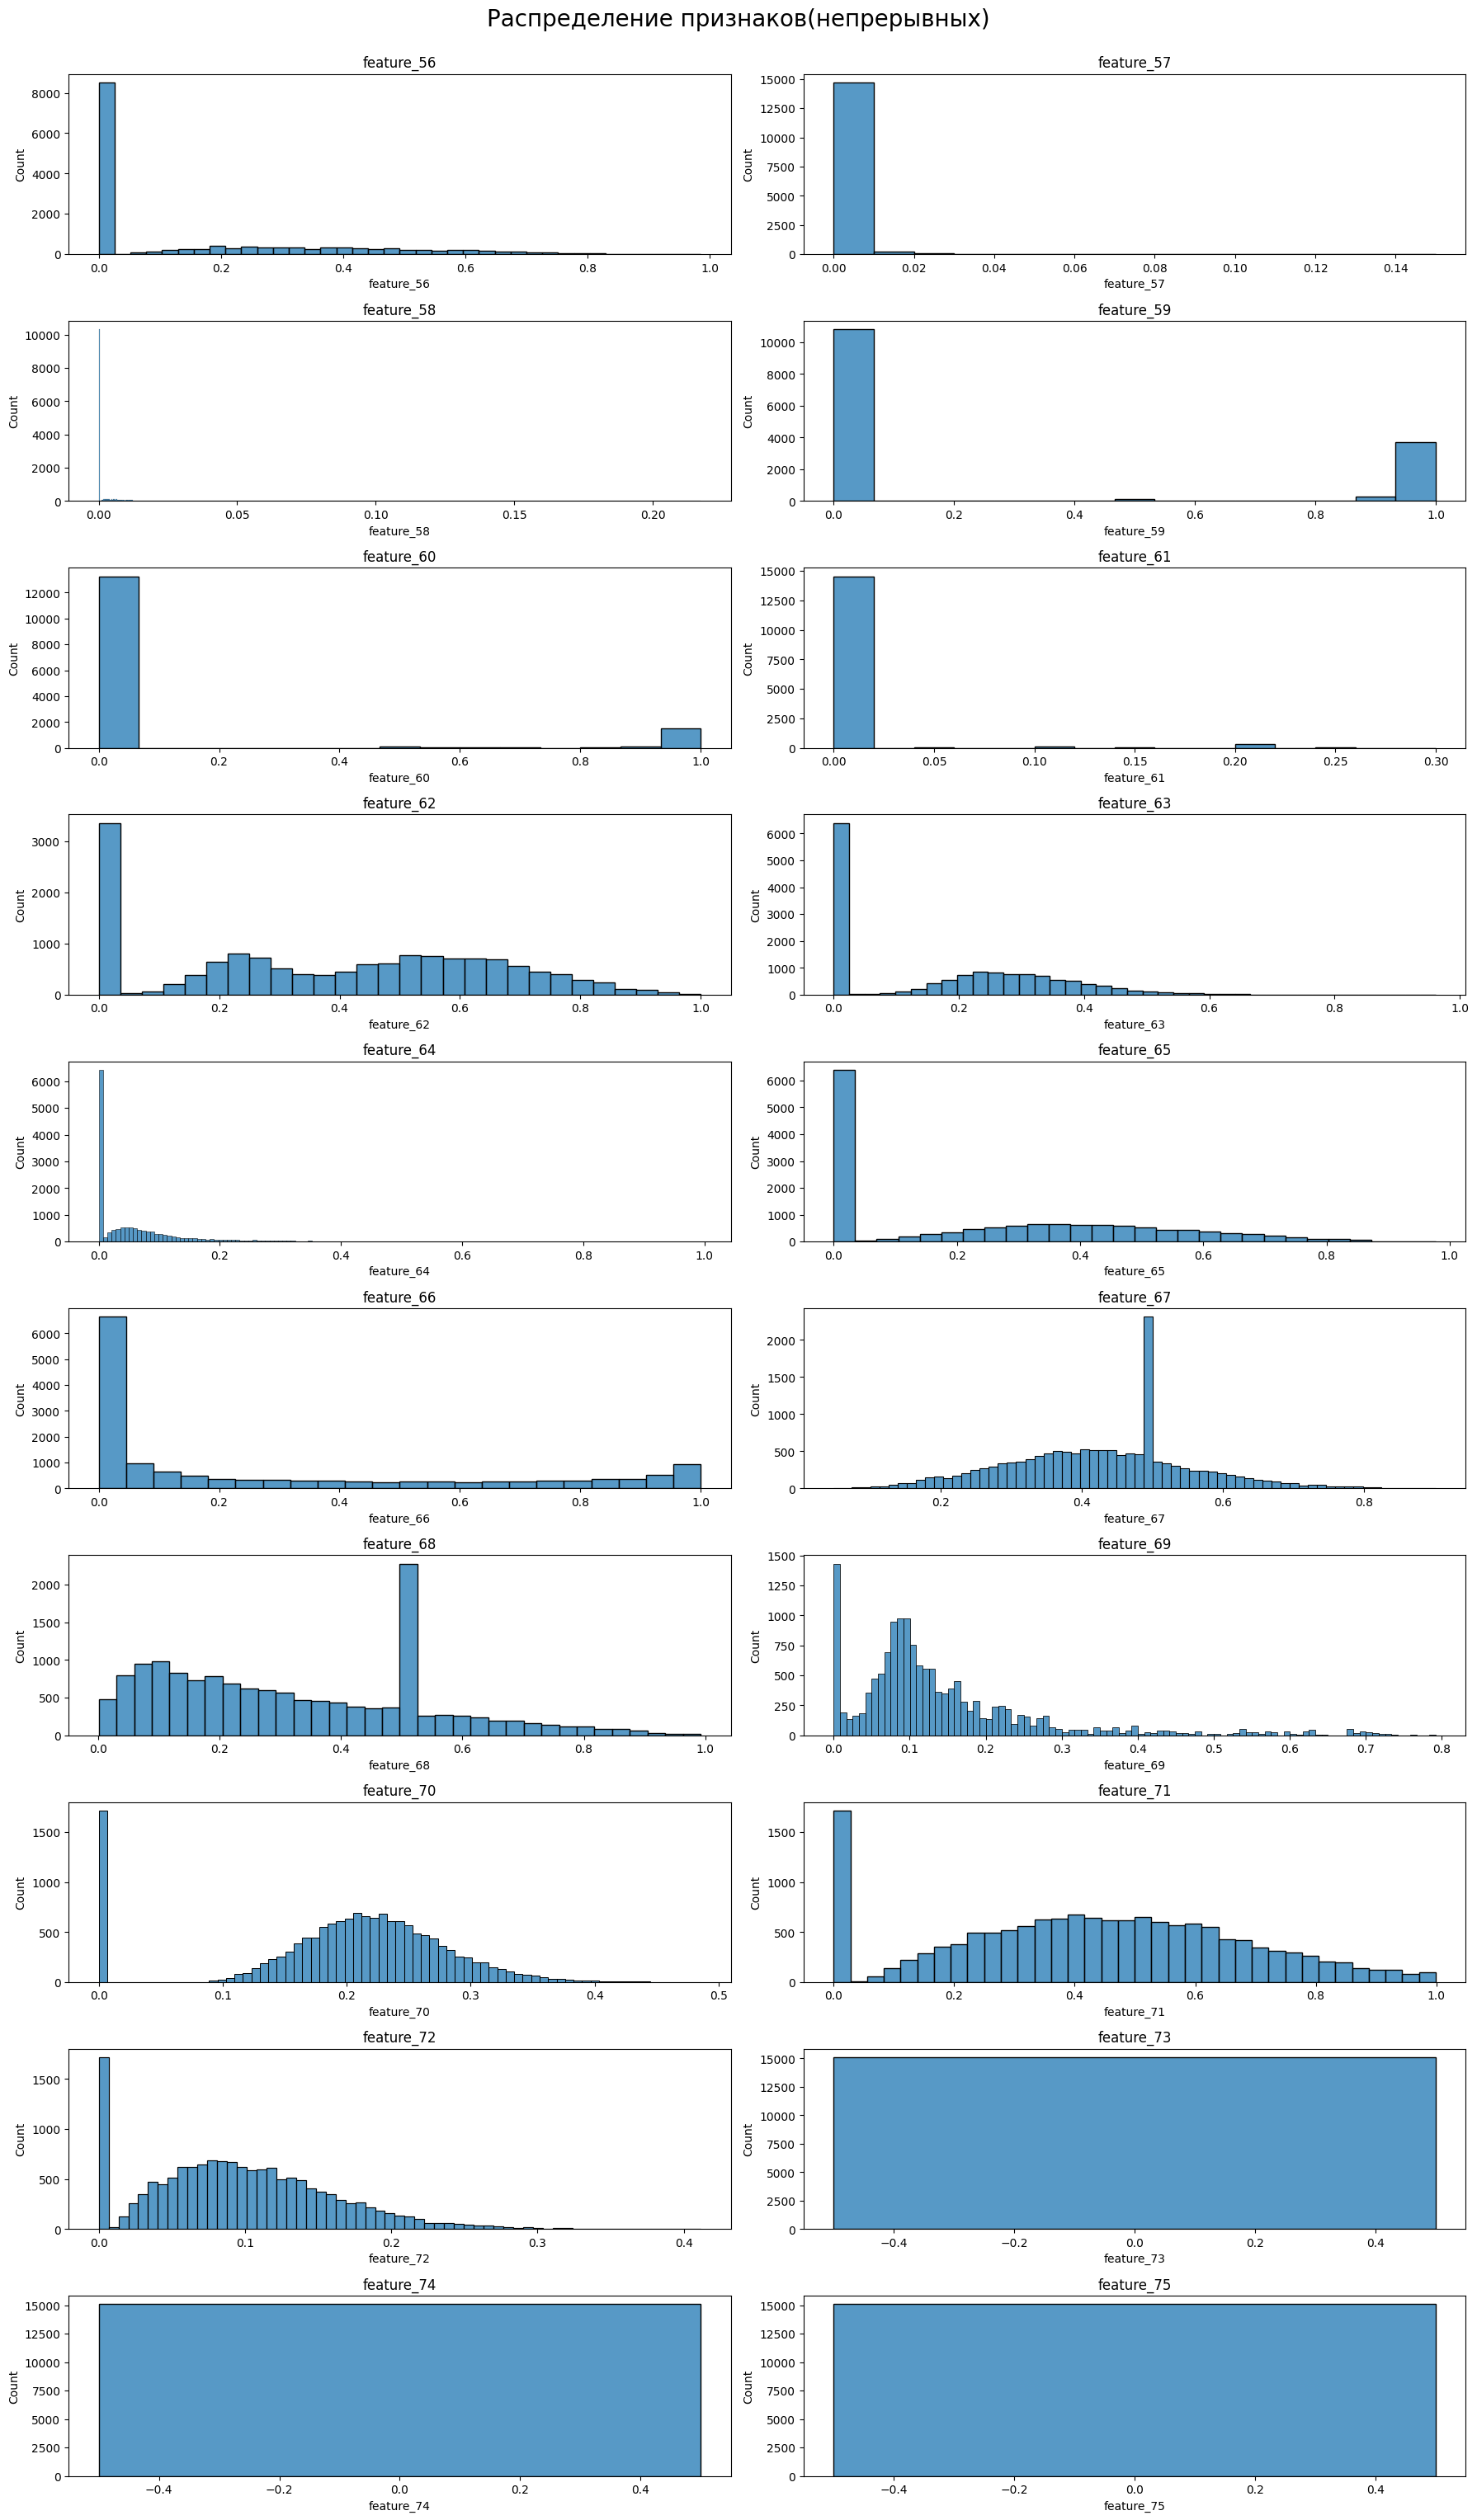

In [13]:
# распределение непрерывных величин
distcol = train.columns[57:77]

plt.figure(figsize=(18, 60))
plt.suptitle("Распределение признаков(непрерывных)", fontsize=20, x=0.5, y=1)
for i, column in enumerate(distcol):
    plt.subplot(len(distcol), 2, i + 1)

    sns.histplot(
        data=train,
        x=column,
        kde=False,
    )
    plt.title(f"{column}")
    plt.tight_layout()

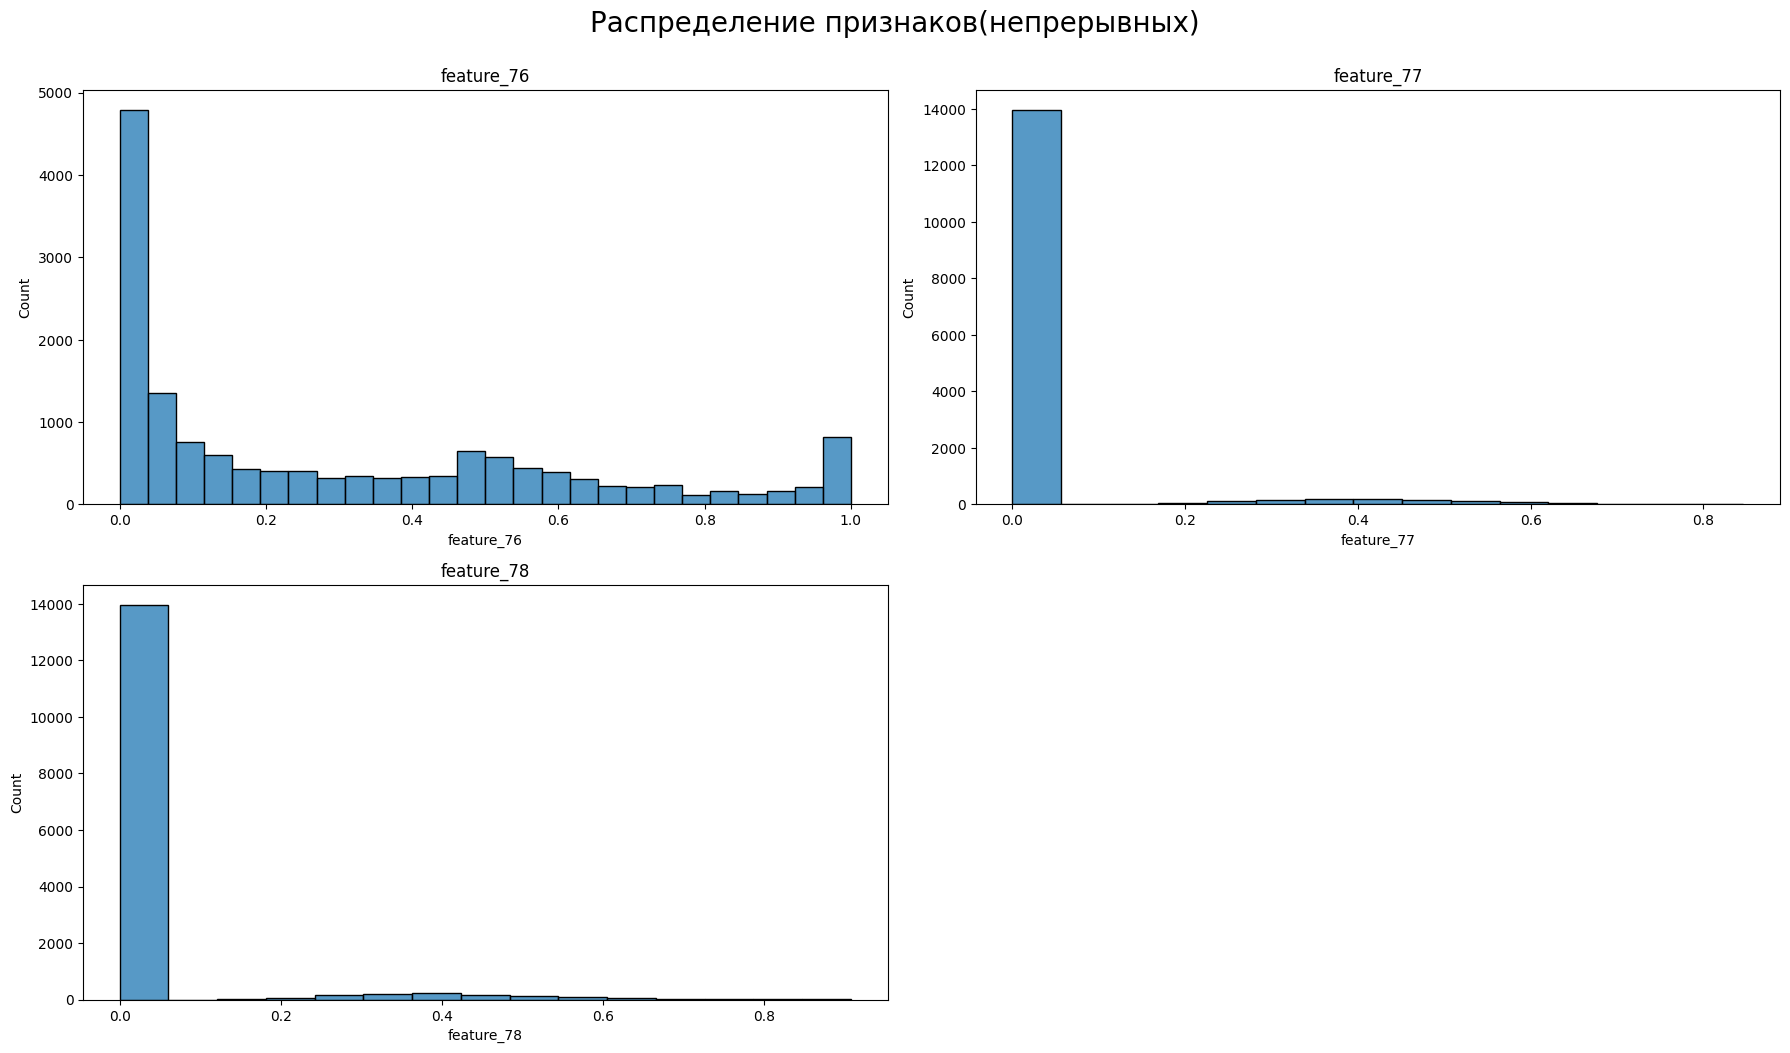

In [14]:
# распределение непрерывных величин
distcol = train.columns[77:80]

plt.figure(figsize=(18, 15))
plt.suptitle("Распределение признаков(непрерывных)", fontsize=20, x=0.5, y=1)
for i, column in enumerate(distcol):
    plt.subplot(len(distcol), 2, i + 1)

    sns.histplot(
        data=train,
        x=column,
        kde=False,
    )
    plt.title(f"{column}")
    plt.tight_layout()

#### Выводы по анализу распределения непрерывных величин:

1) Не все признаки имеют соответствующий тип данных. Возможно, некоторые признаки были неправильно интерпретированы(записаны в файл) как непрерывные, хотя они должны быть категориальными.

2) Анализ графиков распределения признаков позволил сделать следующие выводы:
   - Среди категориальных признаков [feature_0.... feature_15], за исключением feature_6, обнаружены определенные характеристики.
   - Признаки [feature_0, feature_73, feature_74, feature_75] обнаружены с константными значениями, что может быть признаком проблемы с данными.
   - Многие признаки имеют аномальные значения и характеризуются тяжелыми хвостами в распределениях, что может указывать на наличие выбросов или необычных особенностей в данных.


### Таблицы перекрестных частот признаков

In [15]:
# Создаем таблицу перекрестных частот для анализа взаимосвязи между feature_1 и target
pd.crosstab(
    train["feature_1"], train["target"], margins=True
).style.background_gradient()

In [16]:
# Создаем таблицу перекрестных частот для анализа взаимосвязи между [feature_3, feature_5] и target
pd.crosstab(
    [train["feature_3"], train["feature_5"]], train["target"], margins=True
).style.background_gradient()

In [17]:
pd.crosstab(
    [train["feature_15"], train["feature_12"]], train["target"], margins=True
).style.background_gradient()

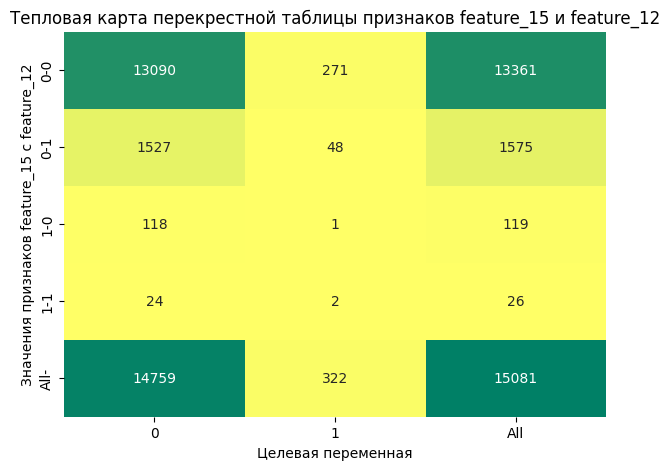

In [18]:
# Создание перекрестной таблицы
cross_tab = pd.crosstab(
    [train["feature_15"], train["feature_12"]], train["target"], margins=True
)

# Построение тепловой карты
plt.figure(figsize=(7, 5))
sns.heatmap(cross_tab, annot=True, cmap="summer_r", fmt="d", cbar=False)
plt.title("Тепловая карта перекрестной таблицы признаков feature_15 и feature_12")
plt.xlabel("Целевая переменная")
plt.ylabel("Значения признаков feature_15 с feature_12")
plt.show()

##### Распределение категориальных переменных(значений) относительно target

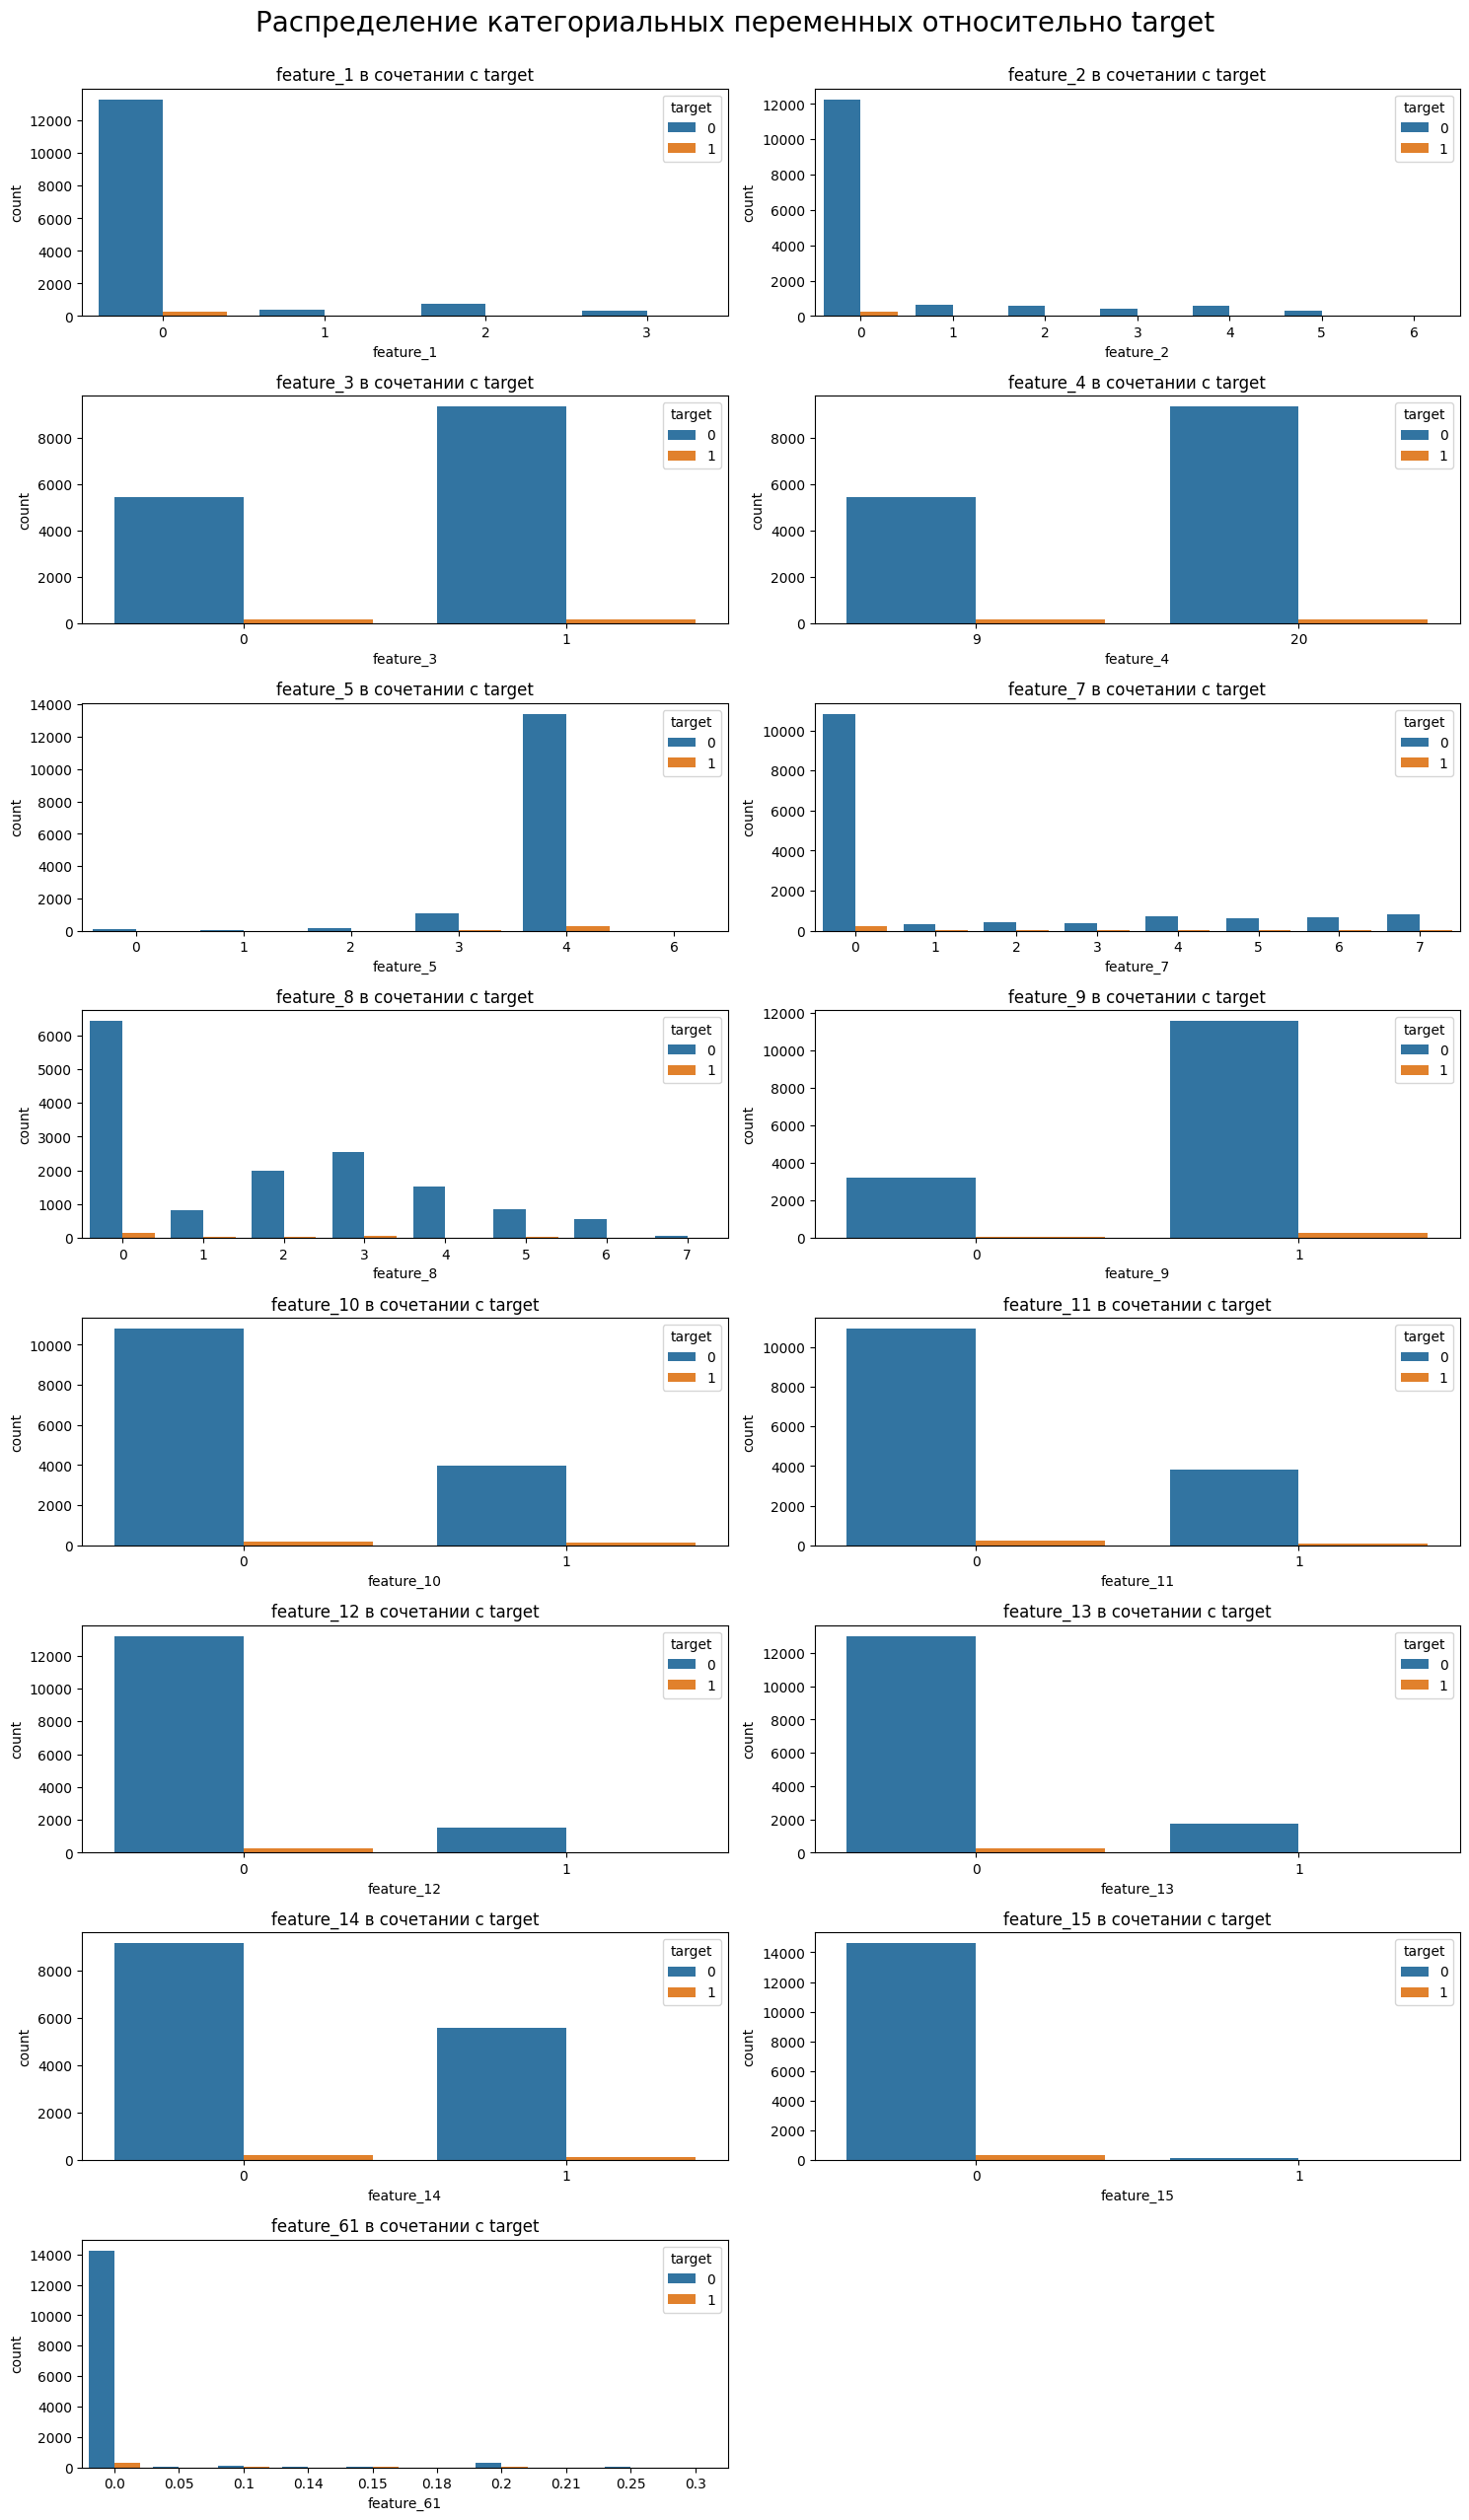

In [19]:
# Распределение категориальных переменных(значений) относительно target

cat_columns = [
    "feature_1",
    "feature_2",
    "feature_3",
    "feature_4",
    "feature_5",
    "feature_7",
    "feature_8",
    "feature_9",
    "feature_10",
    "feature_11",
    "feature_12",
    "feature_13",
    "feature_14",
    "feature_15",
    "feature_61",
]


plt.figure(figsize=(15, 50))
for i, column in enumerate(cat_columns):
    plt.subplot(len(catcol), 2, i + 1)
    plt.suptitle(
        "Распределение категориальных переменных относительно target",
        fontsize=20,
        x=0.5,
        y=1,
    )
    sns.countplot(data=train, x=column, hue="target")

    plt.title(f"{column} в сочетании с target")
    plt.tight_layout()

#### Выводы по анализу распределения категориальных переменных относительно целевой переменной:

1) На основе проведенного анализа можно утверждать, что в каждом категориальном признаке преобладает определенная категория, которая может быть существенной или информативной для целевой переменной. Это указывает на потенциальную важность этих категорий для различения или предсказания классов целевой переменной.

#### Графики скрипичных диаграмм

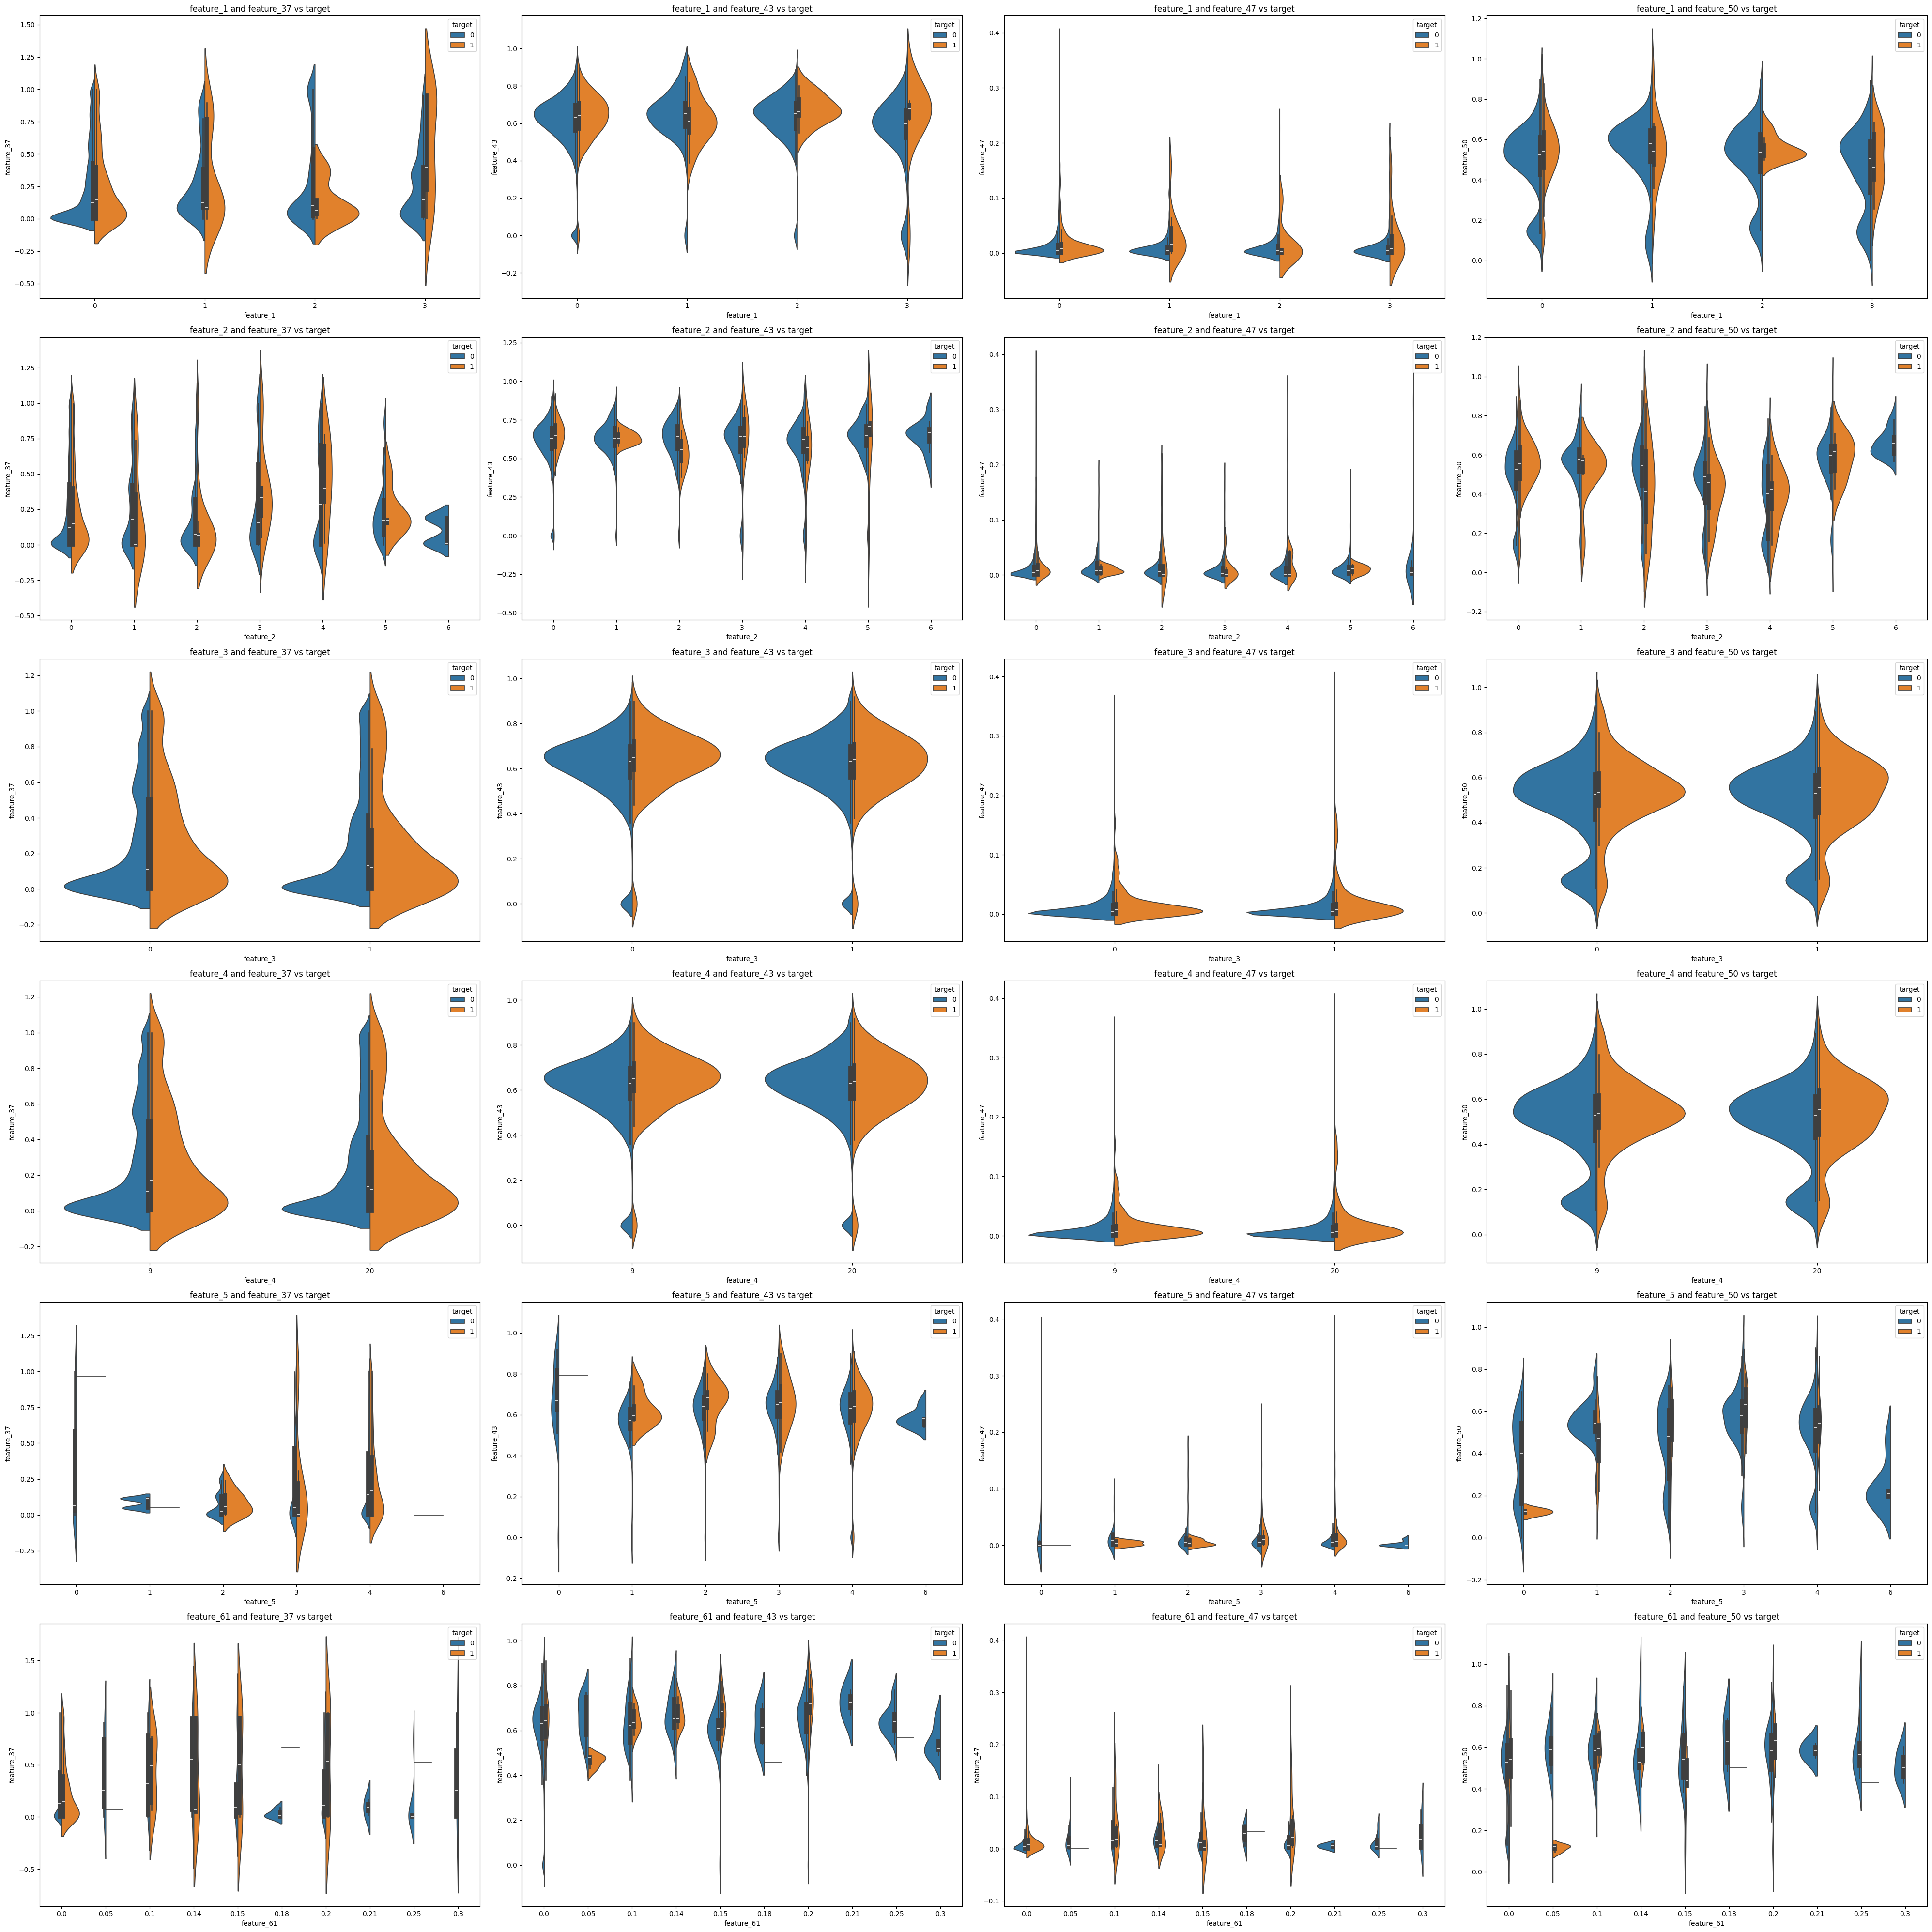

In [20]:
violin_columns_x = [
    "feature_1",
    "feature_2",
    "feature_3",
    "feature_4",
    "feature_5",
    "feature_61",
]

violin_columns_y = ["feature_37", "feature_43", "feature_47", "feature_50"]


# Создание полотна для графиков
fig, axes = plt.subplots(
    nrows=len(violin_columns_x), ncols=len(violin_columns_y), figsize=(40, 40)
)


# Итерация по признакам violin_columns_x
for i, feature_x in enumerate(violin_columns_x):
    # Итерация по признакам violin_columns_y
    for j, feature_y in enumerate(violin_columns_y):
        # Построение скрипичной диаграммы
        sns.violinplot(
            x=feature_x,
            y=feature_y,
            hue="target",
            data=train,
            ax=axes[i, j],
            split=True,
        )
        axes[i, j].set_title(f"{feature_x} and {feature_y} vs target")
        axes[i, j].legend(title="target")

plt.tight_layout()
plt.show()

### Выводы по анализу скрипковых графиков:

1) Визуальный анализ скрипковых графиков позволил также обнаружить наличие выбросов или аномальных значений в распределении каждого признака. Это может указывать на потенциальные ошибки в данных или на необычные особенности взаимосвязей между признаками и целевой переменной.

2) Распределение значений каждого признака в зависимости от целевой переменной в большинстве случаев не является нормальным. Это говорит о том, что влияние признаков на целевую переменную может быть нелинейным или иметь другие нестандартные формы.

3) Некоторые значения признаков могут с высокой точностью предсказывать целевую переменную. Это может указывать на сильную взаимосвязь между этими признаками и целевой переменной, что делает их потенциально важными для моделирования или принятия решений.

#### Графики с усами

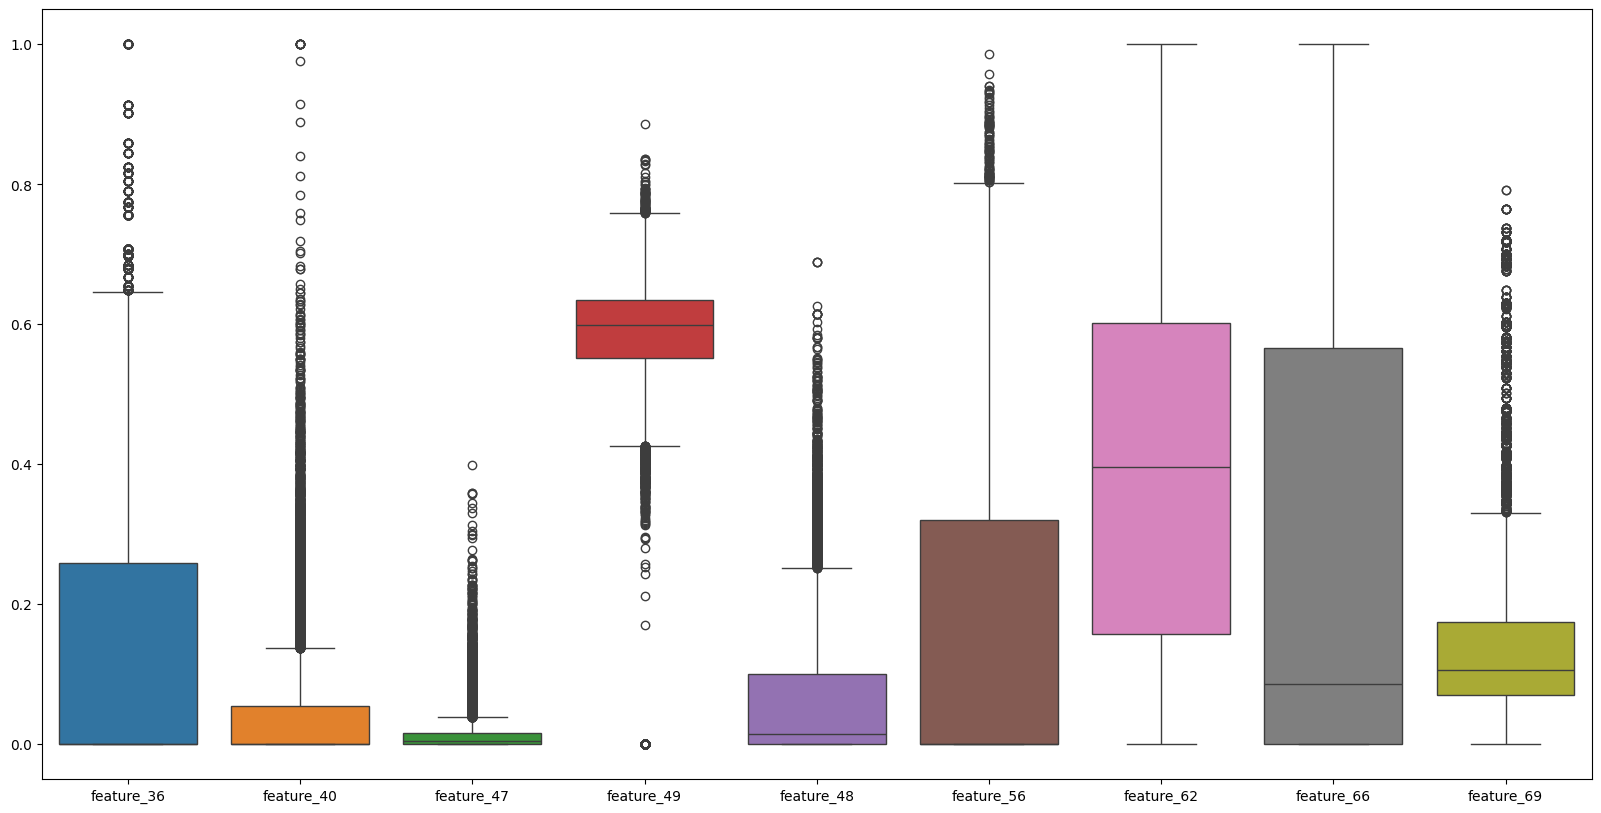

In [21]:
# график с усами
features_list = [
    "feature_36",
    "feature_40",
    "feature_47",
    "feature_49",
    "feature_48",
    "feature_56",
    "feature_62",
    "feature_66",
    "feature_69",
]

plt.figure(figsize=(20, 10))
sns.boxplot(data=train[features_list], orient="v")
plt.show()


#### Выводы по анализу графиков с усами:

1) Некоторые признаки имеют размытую границу первого квартиля, что указывает на наличие значительного разброса вниз по данным. Это может быть признаком наличия выбросов или аномальных значений в распределении данных.

2) Обнаружены значения признаков, которые превышают среднее значение в несколько раз. Это также указывает на наличие экстремальных значений или выбросов в данных, которые могут оказать существенное влияние на результаты анализа.


### Корреляционный анализ

In [22]:
corr_matrix = train.corr()
corr_matrix.head(10)

search_id  feature_0  feature_1  feature_2  feature_3  feature_4  \
search_id   1.000000        NaN  -0.005195  -0.035058   0.034465   0.034465   
feature_0        NaN        NaN        NaN        NaN        NaN        NaN   
feature_1  -0.005195        NaN   1.000000  -0.017054  -0.054672  -0.054672   
feature_2  -0.035058        NaN  -0.017054   1.000000   0.066014   0.066014   
feature_3   0.034465        NaN  -0.054672   0.066014   1.000000   1.000000   
feature_4   0.034465        NaN  -0.054672   0.066014   1.000000   1.000000   
feature_5  -0.023497        NaN   0.038106  -0.008419  -0.007873  -0.007873   
feature_6  -0.008107        NaN   0.045054  -0.024244   0.017213   0.017213   
feature_7  -0.027329        NaN   0.514021  -0.051710  -0.057525  -0.057525   
feature_8  -0.005243        NaN   0.222314  -0.048600   0.005045   0.005045   

           feature_5  feature_6  feature_7  feature_8  ...  feature_70  \
search_id  -0.023497  -0.008107  -0.027329  -0.005243  ...    0.012933   
feature_0        NaN        NaN        NaN        NaN  ...         NaN   
feature_1   0.038106   0.045054   0.514021   0.222314  ...    0.023376   
feature_2  -0.008419  -0.024244  -0.051710  -0.048600  ...   -0.026022   
feature_3  -0.007873   0.017213  -0.057525   0.005045  ...   -0.050584   
feature_4  -0.007873   0.017213  -0.057525   0.005045  ...   -0.050584   
feature_5   1.000000  -0.086111   0.065607   0.049628  ...    0.037763   
feature_6  -0.086111   1.000000  -0.002624   0.105544  ...    0.098794   
feature_7   0.065607  -0.002624   1.000000   0.348050  ...    0.040988   
feature_8   0.049628   0.105544   0.348050   1.000000  ...   -0.014986   

           feature_71  feature_72  feature_73  feature_74  feature_75  \
search_id   -0.006893    0.000358         NaN         NaN         NaN   
feature_0         NaN         NaN         NaN         NaN         NaN   
feature_1    0.076516    0.101744         NaN         NaN         NaN   
feature_2    0.000258   -0.023006         NaN         NaN         NaN   
feature_3    0.142552    0.077396         NaN         NaN         NaN   
feature_4    0.142552    0.077396         NaN         NaN         NaN   
feature_5    0.064221    0.067338         NaN         NaN         NaN   
feature_6   -0.060346   -0.027898         NaN         NaN         NaN   
feature_7    0.190256    0.196547         NaN         NaN         NaN   
feature_8    0.038773    0.043869         NaN         NaN         NaN   

           feature_76  feature_77  feature_78    target  
search_id    0.012530    0.036139    0.023331 -0.005972  
feature_0         NaN         NaN         NaN       NaN  
feature_1    0.022636   -0.025528   -0.023964 -0.000285  
feature_2   -0.028082   -0.005987   -0.001722 -0.008337  
feature_3    0.044092    0.022348    0.023254 -0.037827  
feature_4    0.044092    0.022348    0.023254 -0.037827  
feature_5    0.029528   -0.051923   -0.046336 -0.014845  
feature_6    0.126931   -0.010225   -0.027883  0.016887  
feature_7    0.050992   -0.036952   -0.030444  0.014778  
feature_8   -0.012849    0.002591    0.004053 -0.012561  

[10 rows x 81 columns]

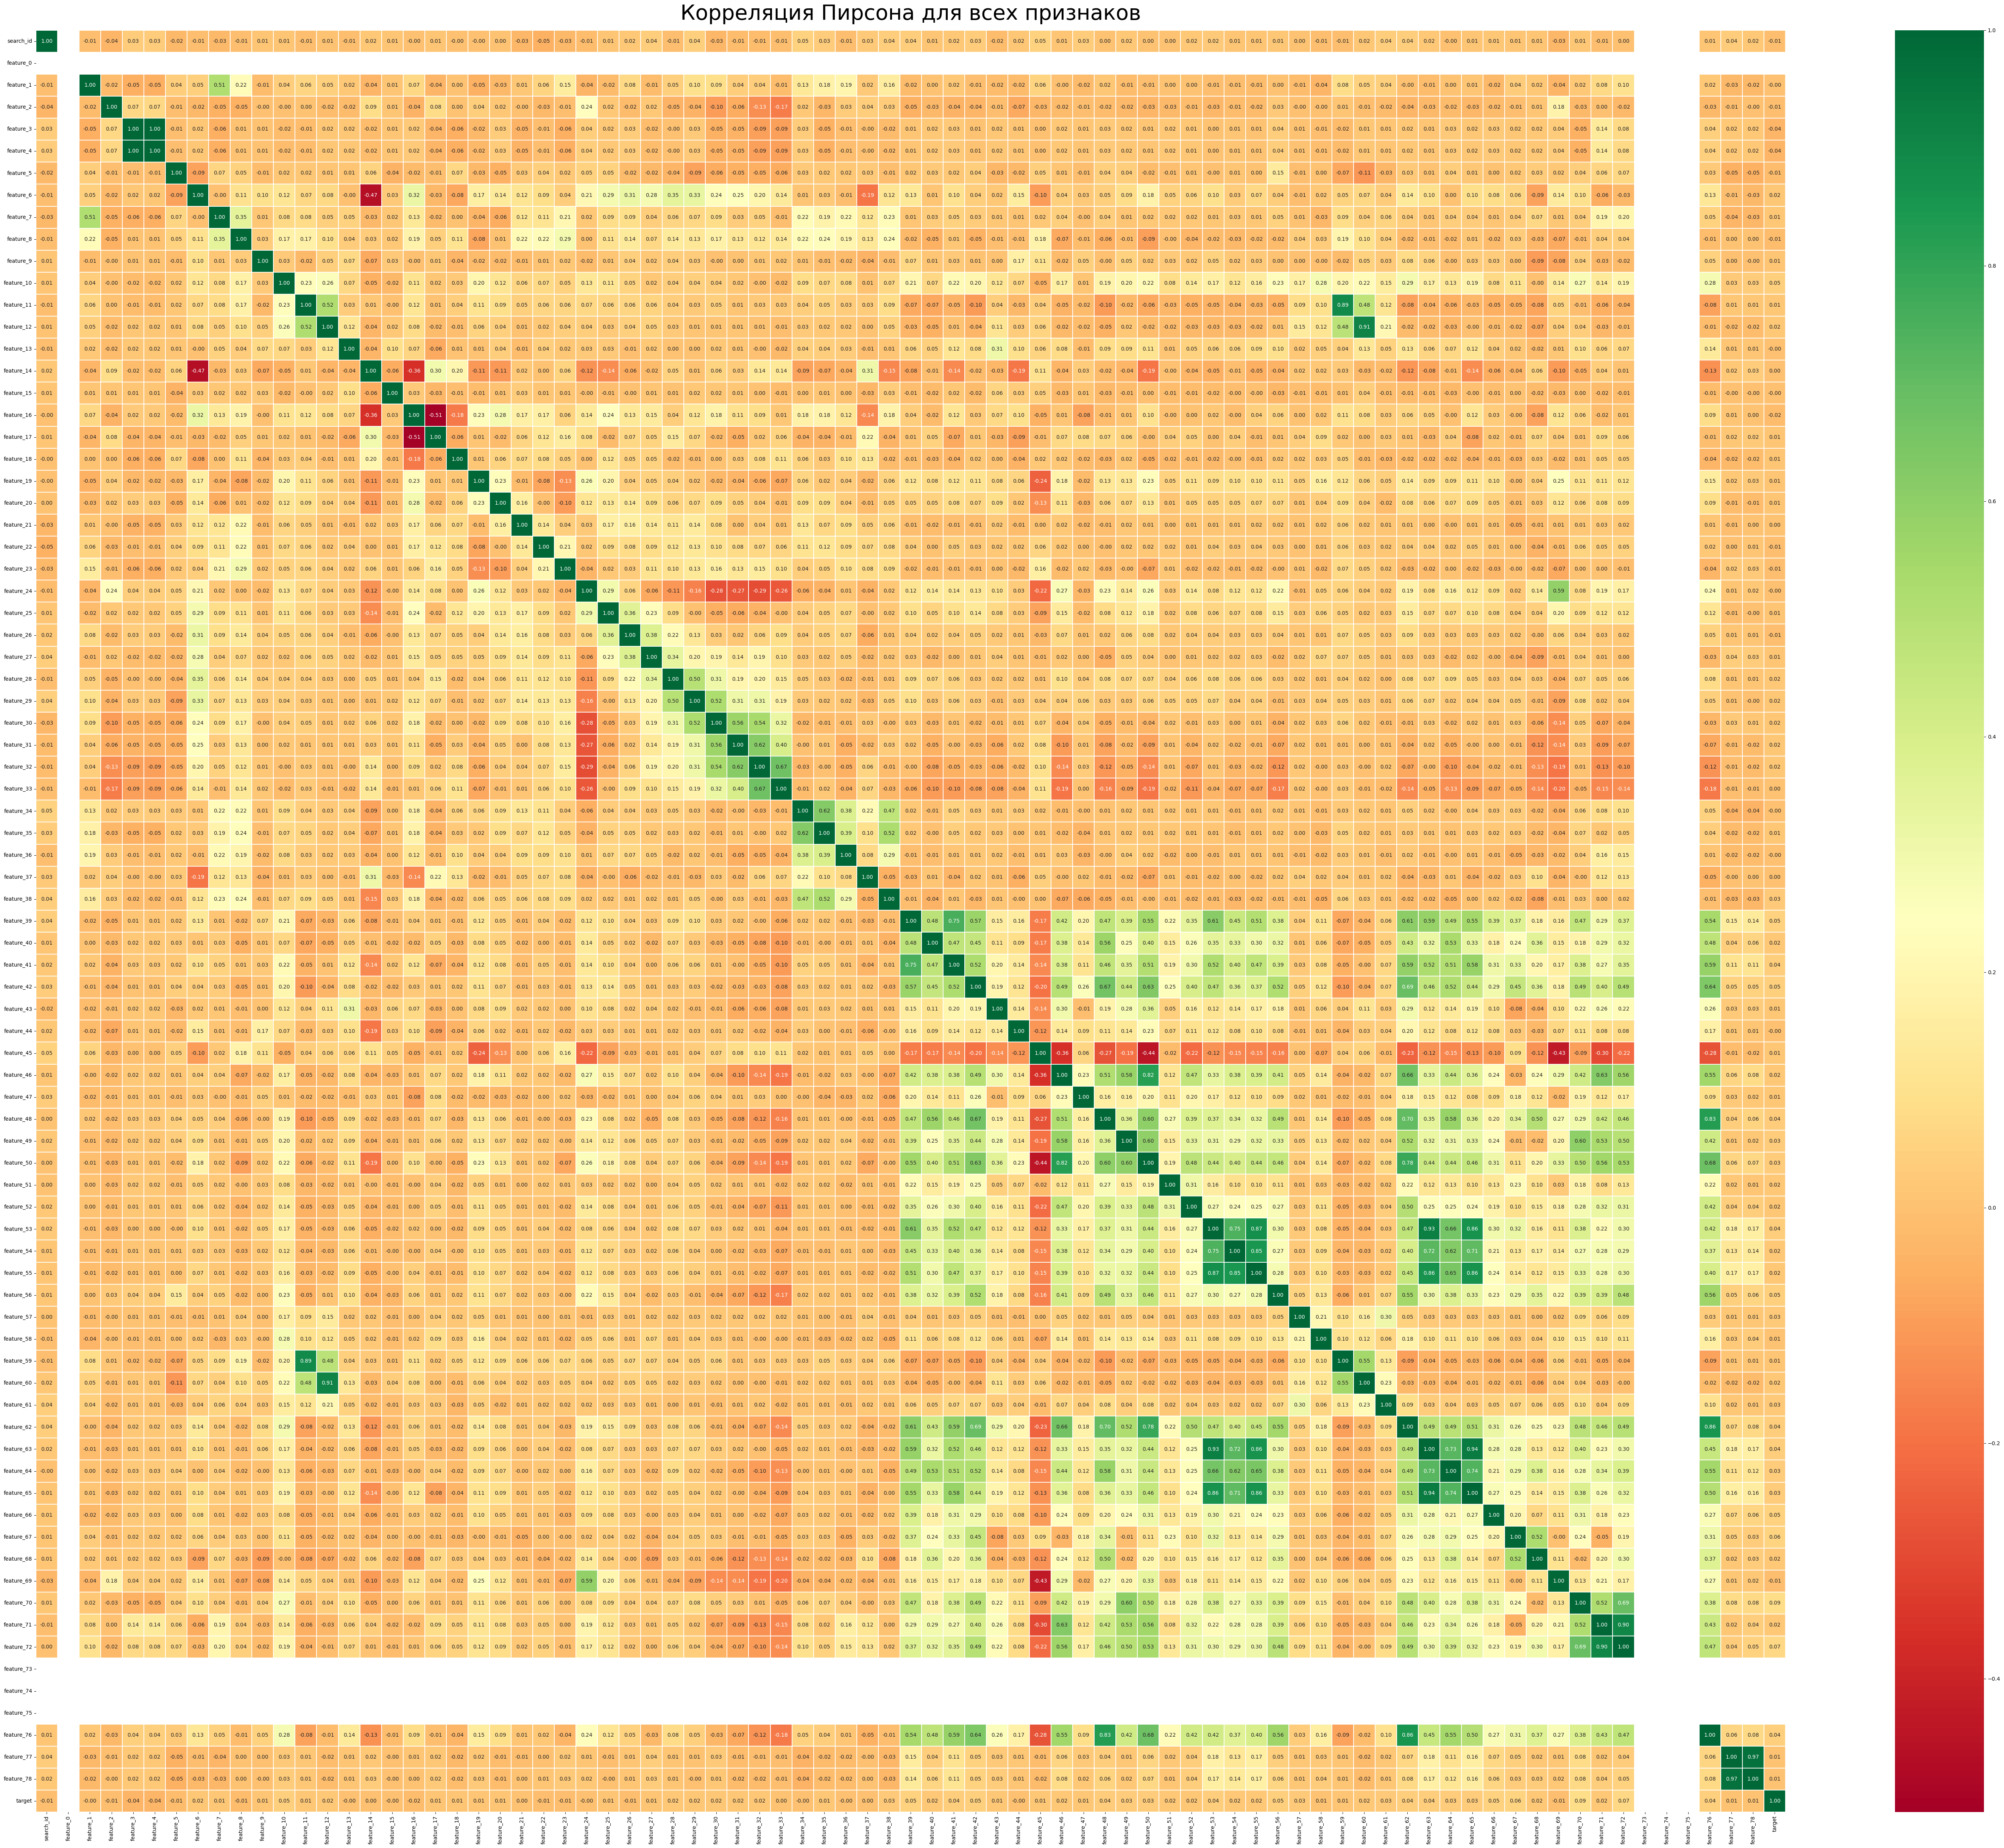

In [23]:
# построим тепловую матрицу корреляций пирсона
plt.figure(figsize=(60, 50))
sns.heatmap(data=corr_matrix, annot=True, cmap="RdYlGn", linewidths=0.2, fmt=".2f")
plt.title(
    "Корреляция Пирсона для всех признаков", fontsize=40, pad=20
)  # Установка размера заголовка и расстояния между заголовком и графиком

plt.tight_layout(pad=5)  # Установка расстояния между заголовком и графиком
plt.show()

#### Топ скорелиррованных признаков

In [24]:
# определение топ скоррелированных признаков
def get_redundant_pairs(df):
    """Определение пар признаков, которые являются лишними (redundant) в матрице корреляции."""

    pairs_to_drop = set()  # Для хранения пар признаков, которые нужно удалить.
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(corr_matrix, n=5):
    au_corr = corr_matrix.abs().unstack()
    labels_to_drop = get_redundant_pairs(corr_matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


print(f"Топ скоррелированных признаков: \n {get_top_abs_correlations(corr_matrix, 20)}")

Топ скоррелированных признаков: 
 feature_3   feature_4     1.000000
feature_77  feature_78    0.967949
feature_63  feature_65    0.937835
feature_53  feature_63    0.925749
feature_12  feature_60    0.907727
feature_71  feature_72    0.900260
feature_11  feature_59    0.889379
feature_53  feature_55    0.872157
feature_55  feature_65    0.862796
feature_53  feature_65    0.860164
feature_55  feature_63    0.859733
feature_62  feature_76    0.857022
feature_54  feature_55    0.847190
feature_48  feature_76    0.825842
feature_46  feature_50    0.821132
feature_50  feature_62    0.781759
feature_39  feature_41    0.753937
feature_53  feature_54    0.745766
feature_64  feature_65    0.739208
feature_63  feature_64    0.725107
dtype: float64


#### Корреляция для категориальных признаков

In [25]:
# Коэффициент V-Крамера (Cramer's V): Этот коэффициент является мерой силы ассоциации между двумя категориальными переменными.
# Мера информационной взаимосвязи (Mutual Information): Это статистическая мера, которая оценивает степень взаимозависимости между двумя случайными переменными
# Мера условной энтропии (Conditional Entropy): Это также статистическая мера, которая оценивает количество информации, необходимое для предсказания одной переменной при наличии другой переменной.
# Для бинарных категориальных переменных можно использовать статистические методы, коэффициенты корреляции Мэтьюса или коэффициенты фи.
# Матрица сопряженности (Contingency Table): Это таблица, которая отображает распределение частот для двух или более категориальных переменных.

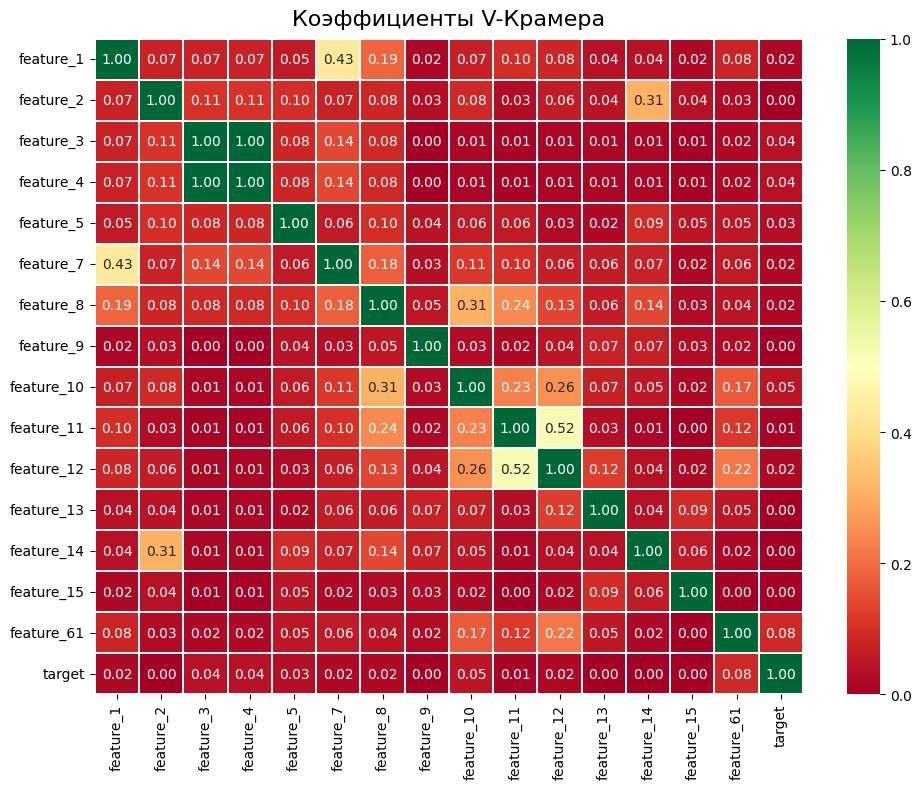

In [26]:
cat_data = train[cat_columns + ["target"]]

# коэффициенты V-Крамера
plot_heatmap(cramers_matrix(cat_data), "Коэффициенты V-Крамера")

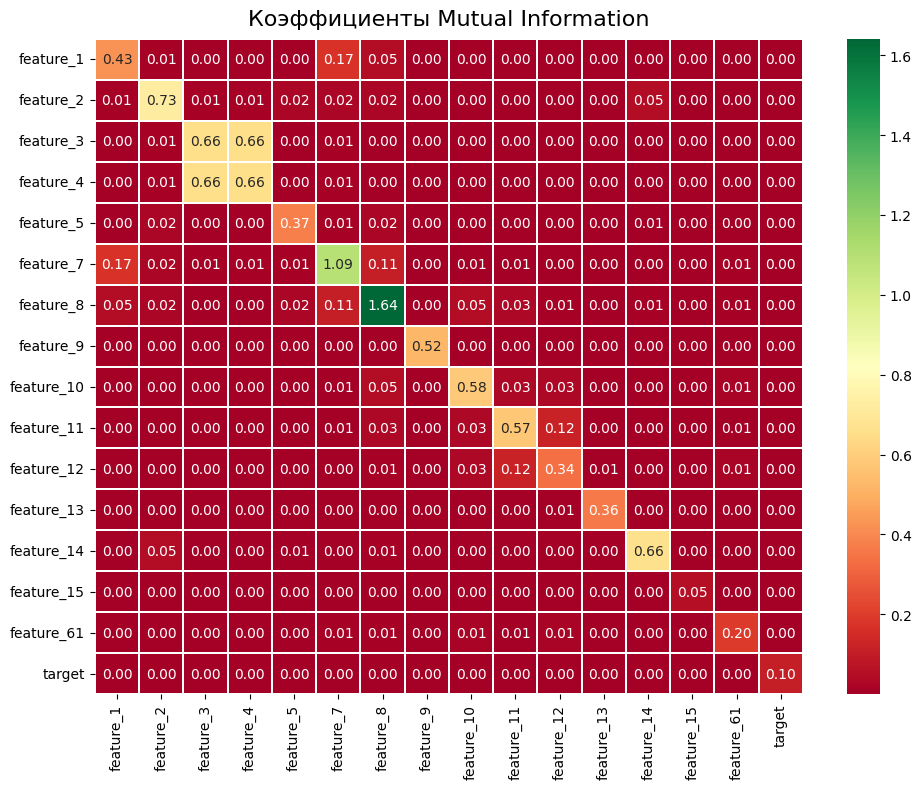

In [27]:
# Коэффициенты Mutual Information

plot_heatmap(
    matrix_data=mutual_information_matrix(cat_data),
    title="Коэффициенты Mutual Information",
)

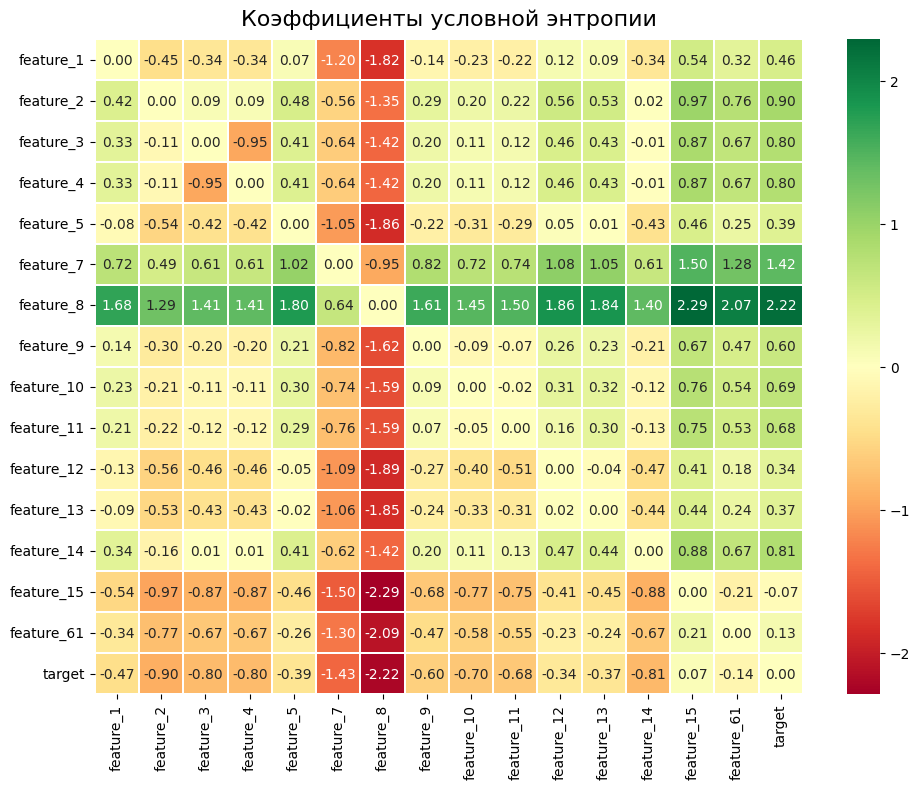

In [28]:
# коэффициенты Conditional Entropy

plot_heatmap(conditional_entropy_matrix(cat_data), "Коэффициенты условной энтропии")

#### Выводы по корреляционному анализу:

Анализ корреляций признаков позволяет понять степень взаимосвязи между ними и выявить потенциальные мультиколлинеарные или взаимосвязанные переменные.

1. **Корреляция Пирсона**:
   - Большинство признаков имеют низкие значения корреляции Пирсона, указывая на слабую линейную связь между ними.
   - Однако признаки `feature_0` и `feature_1` обнаруживают мультиколлинеарность, что может потребовать дополнительного внимания при построении модели.
   - Для 20 признаков корреляция превышает 0.72, что свидетельствует о сильной взаимосвязи между ними.

2. **Коэффициенты V-Крамера**:
   - Большинство признаков демонстрируют низкую ассоциацию с другими переменными. Это указывает на отсутствие явных связей между ними.
   - Для некоторых пар признаков, таких как `feature_1` и `feature_7`, коэффициенты V-Крамера показывают умеренную ассоциацию, что указывает на среднюю степень взаимосвязи между ними.

3. **Условная энтропия**:
   - График условной энтропии практически для всех признаков не показывает значимых связей между ними. Это говорит о том, что значения одного признака не содержат информации о значениях другого признака.

Итак, на основе проведенного анализа, можно сделать вывод о незначительной взаимосвязи между признаками в данном наборе данных, за исключением некоторых пар, которые демонстрируют умеренную ассоциацию.

### Описательная статистика

In [15]:
describe_data = train.describe()
describe_data.T.iloc[35:55]

count      mean       std  min       25%       50%       75%  \
feature_34  15081.0  0.289737  0.199287  0.0  0.000000  0.334730  0.428490   
feature_35  15081.0  0.214519  0.224594  0.0  0.000000  0.214830  0.397280   
feature_36  15081.0  0.126777  0.221260  0.0  0.000000  0.000000  0.258200   
feature_37  15081.0  0.259677  0.303346  0.0  0.000000  0.126580  0.429820   
feature_38  15081.0  0.159871  0.177434  0.0  0.000000  0.000000  0.313900   
feature_39  15081.0  0.097795  0.079860  0.0  0.000000  0.112154  0.159719   
feature_40  15081.0  0.049317  0.102298  0.0  0.000000  0.000000  0.054738   
feature_41  15081.0  0.169746  0.181892  0.0  0.000000  0.157895  0.284611   
feature_42  15081.0  0.162434  0.156926  0.0  0.052332  0.132276  0.226639   
feature_43  15081.0  0.614539  0.150085  0.0  0.560000  0.630000  0.700000   
feature_44  15081.0  0.284323  0.169471  0.0  0.160000  0.300000  0.410000   
feature_45  15081.0  0.392261  0.287153  0.0  0.136470  0.340540  0.620220   
feature_46  15081.0  0.478842  0.263806  0.0  0.364149  0.546524  0.681443   
feature_47  15081.0  0.014419  0.028183  0.0  0.000000  0.005163  0.015453   
feature_48  15081.0  0.066285  0.100083  0.0  0.000000  0.014224  0.100852   
feature_49  15081.0  0.552113  0.171714  0.0  0.550997  0.598761  0.634084   
feature_50  15081.0  0.491591  0.185571  0.0  0.423215  0.528447  0.613359   
feature_51  15081.0  0.050898  0.036735  0.0  0.041393  0.047892  0.056444   
feature_52  15081.0  0.015517  0.016906  0.0  0.000000  0.022779  0.022896   
feature_53  15081.0  0.195384  0.189570  0.0  0.000000  0.216631  0.338755   

                 max  
feature_34  1.000000  
feature_35  1.000000  
feature_36  1.000000  
feature_37  1.000000  
feature_38  0.707110  
feature_39  0.488898  
feature_40  1.000000  
feature_41  1.000000  
feature_42  1.000000  
feature_43  0.940000  
feature_44  0.990000  
feature_45  1.000000  
feature_46  0.994681  
feature_47  0.399220  
feature_48  0.688407  
feature_49  0.886432  
feature_50  1.000000  
feature_51  1.000000  
feature_52  0.997953  
feature_53  0.999997

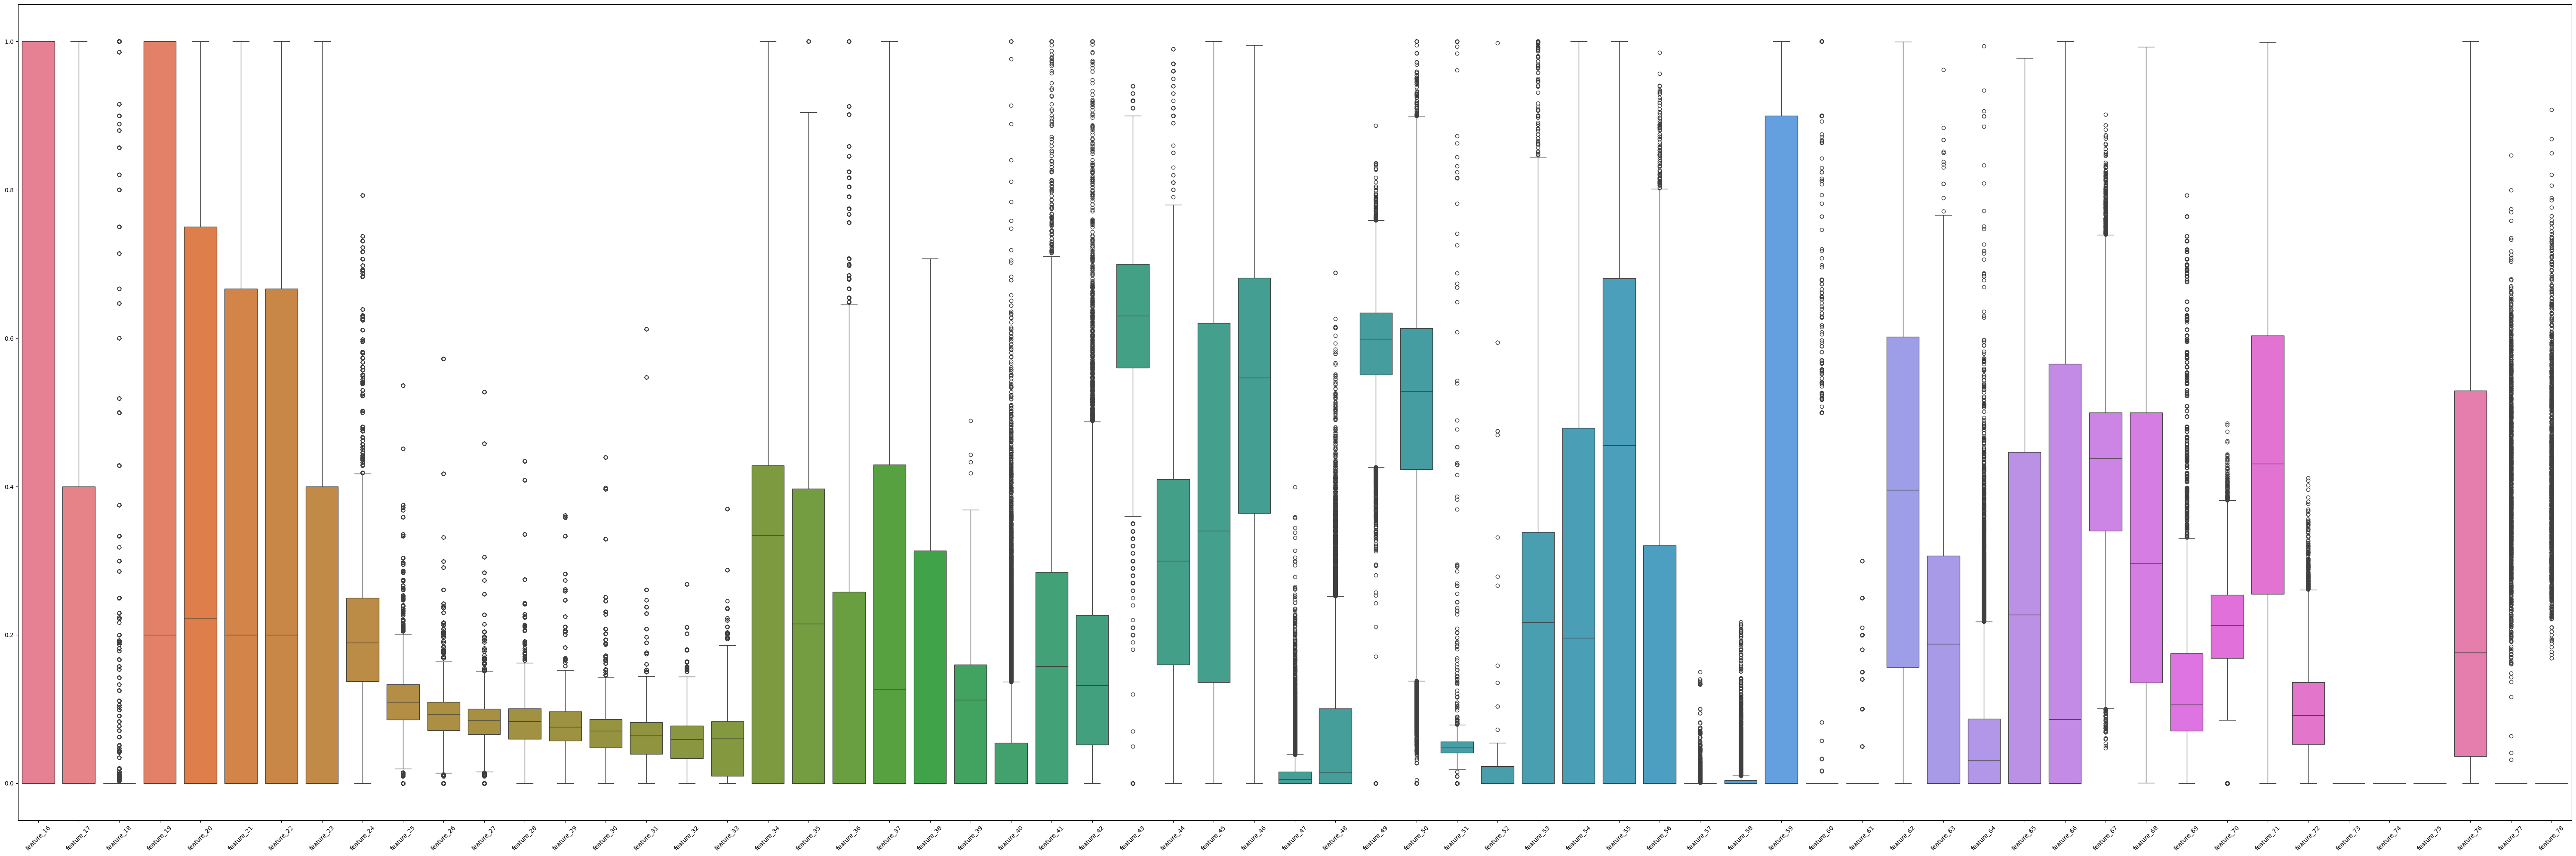

In [24]:
# ячик с усами для всех непрерывных признаков
plt.figure(figsize=(60, 20))
sns.boxplot(data=train.iloc[:, 17:80], orient="v")

plt.xticks(rotation=45)  # поворот подписей по оси x на 45
plt.tight_layout()
plt.show()